In [1]:
library(Seurat)
library(biomaRt)
library(ggplot2)
library(gridExtra)
library(edgeR)
#library(preprocessCore)
#library(sva)
#library(scater)

Attaching SeuratObject

Loading required package: limma



In [ ]:
load("June022023/018-030_RNA_integrated_labeled_with_harmony.RData")

In [9]:
integrated_labeled@assays$SCT@data

  [[ suppressing 32 column names ‘AAACAGCCAAGGTATA-1_1’, ‘AAACAGCCAGGATGGC-1_1’, ‘AAACAGCCAGTAAAGC-1_1’ ... ]]

  [[ suppressing 32 column names ‘AAACAGCCAAGGTATA-1_1’, ‘AAACAGCCAGGATGGC-1_1’, ‘AAACAGCCAGTAAAGC-1_1’ ... ]]

  [[ suppressing 32 column names ‘AAACAGCCAAGGTATA-1_1’, ‘AAACAGCCAGGATGGC-1_1’, ‘AAACAGCCAGTAAAGC-1_1’ ... ]]



32928 x 651012 sparse Matrix of class "dgCMatrix"
                                                                                  
AL627309.1   .         .         .         .         .         .         .        
AL627309.3   .         .         .         .         .         .         .        
AL627309.5   .         .         .         .         .         .         .        
AL627309.4   .         .         .         .         .         .         .        
AP006222.2   .         .         .         .         .         .         .        
AL669831.2   .         .         .         .         .         .         .        
LINC01409    .         .         .         0.6931472 .         .         .        
FAM87B       .         .         .         .         .         .         .        
LINC01128    .         0.6931472 .         .         .         .         .        
LINC00115    .         .         .         .         .         .         0.6931472
FAM41C       .         .         .   

In [10]:
DefaultAssay(integrated_labeled) <- "RNA"
integrated_labeled[["SCT"]] <- NULL
integrated_labeled[["integrated"]] <- NULL

In [2]:
expr <- readRDS("100line_RNAonly.rds")

In [3]:
expr100 <- subset(expr, cell.type %in% c("GABA","nmglut","npglut"))
dim(expr100)

[1]  36601 548800

In [4]:
saveRDS(expr100, "100line_RNAonly_3ct.rds")

In [1]:
expr100 <- readRDS("100line_RNAonly_3ct.rds")

In [6]:
table(expr100$seq.batch.ident)


   018    022    024    025    029    030 
 44076  17596  90027 158393 136710 101998 

In [7]:
table(expr100$cell.line.ident)


  CD_02   CD_03   CD_04   CD_05   CD_06   CD_07   CD_08   CD_09   CD_10   CD_11 
   5082    5013    5350   11872    6258    7317    6942    4936    7552    5811 
  CD_12   CD_13   CD_14   CD_15   CD_16   CD_17   CD_18   CD_19   CD_21   CD_22 
   3631    4671    8076    5873    7039    5558    5473    5542    5570    7769 
  CD_23   CD_25   CD_26   CD_27   CD_31   CD_32   CD_33   CD_34   CD_35   CD_36 
   6689    6430    7651   10570    5218    3039    8381    5076    8252    3182 
  CD_37   CD_38   CD_39   CD_40   CD_42   CD_43   CD_44   CD_45   CD_46   CD_47 
   5188    3543    2807    5378    3392    2447    5836    3678    5611    6094 
  CD_48   CD_49   CD_50   CD_51   CD_52   CD_53   CD_54   CD_55   CD_56   CD_57 
   5693    4497    3827    6010    3845    5108   12483    5490   11087    4221 
  CD_58   CD_60   CD_61   CD_62   CD_63   CD_64   CD_65   CD_66 CW20058 CW20063 
   5664    3801    5223    7615    4689    4754    6648    5202    5043    5203 
CW20077 CW20079 CW20080 CW2

In [18]:
table(expr100$seq.batch.ident[startsWith(expr100$cell.line.ident,"CW")])


   029    030 
136710  72436 

In [12]:
table(expr100$cell.line.ident[expr100$seq.batch.ident=="022"])


CD_32 CD_42 CD_43 CD_49 CD_57 
 3039  3392  2447  4497  4221 

In [15]:
temp <- table(expr100$cell.line.ident)
temp[order(temp)]


  CD_43 CW20077   CD_39 CW70030   CD_32   CD_36 CW50094   CD_42 CW20137 CW20112 
   2447    2629    2807    2895    3039    3182    3326    3392    3392    3422 
CW50150 CW50021   CD_38   CD_12 CW30154   CD_45 CW20111   CD_60 CW70079   CD_50 
   3456    3496    3543    3631    3655    3678    3768    3801    3808    3827 
  CD_52 CW50037 CW50099 CW60060 CW70282   CD_57 CW70305 CW50059   CD_49 CW70344 
   3845    4092    4095    4157    4212    4221    4275    4373    4497    4516 
CW50023 CW70330   CD_13   CD_63 CW20079   CD_64 CW50148 CW60109 CW60134 CW30525 
   4578    4600    4671    4689    4725    4754    4804    4809    4866    4918 
  CD_09 CW20087   CD_03 CW20058   CD_34   CD_02   CD_53 CW20088 CW50040   CD_37 
   4936    4954    5013    5043    5076    5082    5108    5123    5150    5188 
  CD_66 CW20063   CD_31   CD_61   CD_04   CD_40 CW70224   CD_18   CD_55   CD_19 
   5202    5203    5218    5223    5350    5378    5448    5473    5490    5542 
  CD_17   CD_21   CD_46 CW7

In [23]:
expr100$aggr.ident <- paste(expr100$cell.type, expr100$cell.line.ident, sep="|")

In [38]:
### Compute cell type proportion for each individual
cellprop <- matrix(as.numeric(table(expr100$aggr.ident)), ncol=3)
colnames(cellprop) <- c("GABA","nmglut","npglut")
rownames(cellprop) <- names(table(expr100$cell.line.ident))
cellprop1 <- cellprop /rowSums(cellprop)
head(cellprop1)

GABA      nmglut    npglut   
CD_02 0.2731208 0.4635970 0.2632822
CD_03 0.4759625 0.3044085 0.2196290
CD_04 0.4327103 0.4114019 0.1558879
CD_05 0.5702493 0.1746968 0.2550539
CD_06 0.4058805 0.3967721 0.1973474
CD_07 0.4758781 0.3565669 0.1675550

In [39]:
write.table(cellprop1, "mateqtl_input_100lines/aggr_all_cell_expr/cell_proportion.txt", quote=F)

In [32]:
table(expr100$cell.line.ident)


  CD_02   CD_03   CD_04   CD_05   CD_06   CD_07   CD_08   CD_09   CD_10   CD_11 
   5082    5013    5350   11872    6258    7317    6942    4936    7552    5811 
  CD_12   CD_13   CD_14   CD_15   CD_16   CD_17   CD_18   CD_19   CD_21   CD_22 
   3631    4671    8076    5873    7039    5558    5473    5542    5570    7769 
  CD_23   CD_25   CD_26   CD_27   CD_31   CD_32   CD_33   CD_34   CD_35   CD_36 
   6689    6430    7651   10570    5218    3039    8381    5076    8252    3182 
  CD_37   CD_38   CD_39   CD_40   CD_42   CD_43   CD_44   CD_45   CD_46   CD_47 
   5188    3543    2807    5378    3392    2447    5836    3678    5611    6094 
  CD_48   CD_49   CD_50   CD_51   CD_52   CD_53   CD_54   CD_55   CD_56   CD_57 
   5693    4497    3827    6010    3845    5108   12483    5490   11087    4221 
  CD_58   CD_60   CD_61   CD_62   CD_63   CD_64   CD_65   CD_66 CW20058 CW20063 
   5664    3801    5223    7615    4689    4754    6648    5202    5043    5203 
CW20077 CW20079 CW20080 CW2

In [22]:
table(expr100$cell.line.ident)


  CD_02   CD_03   CD_04   CD_05   CD_06   CD_07   CD_08   CD_09   CD_10   CD_11 
   5082    5013    5350   11872    6258    7317    6942    4936    7552    5811 
  CD_12   CD_13   CD_14   CD_15   CD_16   CD_17   CD_18   CD_19   CD_21   CD_22 
   3631    4671    8076    5873    7039    5558    5473    5542    5570    7769 
  CD_23   CD_25   CD_26   CD_27   CD_31   CD_32   CD_33   CD_34   CD_35   CD_36 
   6689    6430    7651   10570    5218    3039    8381    5076    8252    3182 
  CD_37   CD_38   CD_39   CD_40   CD_42   CD_43   CD_44   CD_45   CD_46   CD_47 
   5188    3543    2807    5378    3392    2447    5836    3678    5611    6094 
  CD_48   CD_49   CD_50   CD_51   CD_52   CD_53   CD_54   CD_55   CD_56   CD_57 
   5693    4497    3827    6010    3845    5108   12483    5490   11087    4221 
  CD_58   CD_60   CD_61   CD_62   CD_63   CD_64   CD_65   CD_66 CW20058 CW20063 
   5664    3801    5223    7615    4689    4754    6648    5202    5043    5203 
CW20077 CW20079 CW20080 CW2

In [6]:
psbulk <- AggregateExpression(expr100, slot="counts", group.by = "aggr.ident")
dim(psbulk$RNA)

[1] 36601   900

In [7]:
summary(rowSums(psbulk$RNA))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
        0       291      3628    117563     56894 101460967 

In [8]:
write.table(psbulk$RNA, "/project/xinhe/lifan/neuron_stim/mateqtl_input_100lines/psbulk_100line_raw.txt", sep="\t", quote=F)

In [4]:
table(integrated_labeled$cell.line.ident)


  CD_02   CD_03   CD_04   CD_05   CD_06   CD_07   CD_08   CD_09   CD_10   CD_11 
   6591    5822    6215   14887    8155    9177    8361    6170    8812    6645 
  CD_12   CD_13   CD_14   CD_15   CD_16   CD_17   CD_18   CD_19   CD_21   CD_22 
   4088    5305   12446    6531    8148    6646    6504    6203    6441    9130 
  CD_23   CD_25   CD_26   CD_27   CD_31   CD_32   CD_33   CD_34   CD_35   CD_36 
   7679    7840    9098   13524    5912    3486   10342    6251    9780    3640 
  CD_37   CD_38   CD_39   CD_40   CD_42   CD_43   CD_44   CD_45   CD_46   CD_47 
   5984    4204    3428    6210    3920    3484    6645    4460    6658    7734 
  CD_48   CD_49   CD_50   CD_51   CD_52   CD_53   CD_54   CD_55   CD_56   CD_57 
   6511    5022    4662    6963    4513    5847   15867    6389   13028    4789 
  CD_58   CD_60   CD_61   CD_62   CD_63   CD_64   CD_65   CD_66 CW20058 CW20063 
   6976    4782    6252    8748    5835    5765    7570    6226    5733    6121 
CW20077 CW20079 CW20080 CW2

## Renormalize gene expression together and regress out some covariates (04/03/2024)

1. Remove samples in sequencing batch 22 or total read count less than 1 million.
2. TMM normalze all the remaining samples
3. Remove genes according to previous gene selection
4. Inverse Normal Transformation
5. Regress out covariates except expression PC
6. Compute expression PC on residual gene expression

In [2]:
psbulk.raw <- read.table("/project/xinhe/lifan/neuron_stim/mateqtl_input_100lines/psbulk_100line_raw.txt", header=T)
head(psbulk.raw)

CD_02_0hr_GABA CD_03_0hr_GABA CD_04_0hr_GABA CD_05_0hr_GABA
MIR1302-2HG 0              1              0               0            
FAM138A     0              0              0               0            
OR4F5       0              0              0               0            
AL627309.1  4              4              3              17            
AL627309.3  0              0              0               0            
AL627309.2  0              1              0               0            
            CD_06_0hr_GABA CD_07_0hr_GABA CD_08_0hr_GABA CD_09_0hr_GABA
MIR1302-2HG 0              1              0              0             
FAM138A     0              0              0              0             
OR4F5       0              0              0              0             
AL627309.1  6              8              2              4             
AL627309.3  0              0              0              0             
AL627309.2  0              0              0              0             
            CD_10_0hr_GABA CD_11_0hr_GABA ⋯ CW70142_6hr_npglut
MIR1302-2HG  1             0              ⋯  0                
FAM138A      0             0              ⋯  0                
OR4F5        0             0              ⋯  0                
AL627309.1  12             8              ⋯ 27                
AL627309.3   0             0              ⋯  0                
AL627309.2   0             0              ⋯  0                
            CW70177_6hr_npglut CW70179_6hr_npglut CW70224_6hr_npglut
MIR1302-2HG 0                   1                  0                
FAM138A     0                   0                  0                
OR4F5       0                   0                  0                
AL627309.1  9                  40                 19                
AL627309.3  0                   0                  0                
AL627309.2  0                   0                  0                
            CW70282_6hr_npglut CW70305_6hr_npglut CW70316_6hr_npglut
MIR1302-2HG  0                  0                  0                
FAM138A      0                  0                  0                
OR4F5        0                  0                  0                
AL627309.1  12                 20                 12                
AL627309.3   1                  0                  0                
AL627309.2   0                  0                  0                
            CW70330_6hr_npglut CW70344_6hr_npglut CW70372_6hr_npglut
MIR1302-2HG 0                   0                  0                
FAM138A     0                   0                  0                
OR4F5       0                   0                  0                
AL627309.1  7                  19                 47                
AL627309.3  0                   0                  0                
AL627309.2  0                   0                  0

In [1]:
snps <- data.table::fread("mateqtl_input_100lines/snpsloc.txt.gz")
dim(snps)

[1] 5966820       3

In [3]:
celllines <- sapply(strsplit(colnames(psbulk.raw), "_"), function(x) {
    ifelse(nchar(x[1])==2, paste0(x[1],"_",x[2]), x[1])})
ct <- sapply(strsplit(colnames(psbulk.raw), "_"), function(x) {
    ifelse(nchar(x[1])==2, paste0(x[3],"_",x[4]), paste0(x[2],"_",x[3]))})
colnames(psbulk.raw) <- paste(celllines, ct, sep="|")
head(psbulk.raw)

CD_02|0hr_GABA CD_03|0hr_GABA CD_04|0hr_GABA CD_05|0hr_GABA
MIR1302-2HG 0              1              0               0            
FAM138A     0              0              0               0            
OR4F5       0              0              0               0            
AL627309.1  4              4              3              17            
AL627309.3  0              0              0               0            
AL627309.2  0              1              0               0            
            CD_06|0hr_GABA CD_07|0hr_GABA CD_08|0hr_GABA CD_09|0hr_GABA
MIR1302-2HG 0              1              0              0             
FAM138A     0              0              0              0             
OR4F5       0              0              0              0             
AL627309.1  6              8              2              4             
AL627309.3  0              0              0              0             
AL627309.2  0              0              0              0             
            CD_10|0hr_GABA CD_11|0hr_GABA ⋯ CW70142|6hr_npglut
MIR1302-2HG  1             0              ⋯  0                
FAM138A      0             0              ⋯  0                
OR4F5        0             0              ⋯  0                
AL627309.1  12             8              ⋯ 27                
AL627309.3   0             0              ⋯  0                
AL627309.2   0             0              ⋯  0                
            CW70177|6hr_npglut CW70179|6hr_npglut CW70224|6hr_npglut
MIR1302-2HG 0                   1                  0                
FAM138A     0                   0                  0                
OR4F5       0                   0                  0                
AL627309.1  9                  40                 19                
AL627309.3  0                   0                  0                
AL627309.2  0                   0                  0                
            CW70282|6hr_npglut CW70305|6hr_npglut CW70316|6hr_npglut
MIR1302-2HG  0                  0                  0                
FAM138A      0                  0                  0                
OR4F5        0                  0                  0                
AL627309.1  12                 20                 12                
AL627309.3   1                  0                  0                
AL627309.2   0                  0                  0                
            CW70330|6hr_npglut CW70344|6hr_npglut CW70372|6hr_npglut
MIR1302-2HG 0                   0                  0                
FAM138A     0                   0                  0                
OR4F5       0                   0                  0                
AL627309.1  7                  19                 47                
AL627309.3  0                   0                  0                
AL627309.2  0                   0                  0

In [4]:
sample.rc <- colSums(psbulk.raw)
drop <- names(sample.rc)[sample.rc<1e6]
drop

[1] "CD_32|0hr_GABA"     "CD_36|0hr_GABA"     "CD_49|0hr_GABA"    
 [4] "CD_61|0hr_GABA"     "CD_63|0hr_GABA"     "CW30154|0hr_GABA"  
 [7] "CD_32|1hr_GABA"     "CD_61|1hr_GABA"     "CW30154|1hr_GABA"  
[10] "CW30154|6hr_GABA"   "CD_12|0hr_nmglut"   "CD_13|0hr_nmglut"  
[13] "CD_15|0hr_nmglut"   "CD_18|0hr_nmglut"   "CD_32|0hr_nmglut"  
[16] "CD_36|0hr_nmglut"   "CD_38|0hr_nmglut"   "CD_40|0hr_nmglut"  
[19] "CD_42|0hr_nmglut"   "CD_43|0hr_nmglut"   "CD_44|0hr_nmglut"  
[22] "CD_45|0hr_nmglut"   "CD_48|0hr_nmglut"   "CD_49|0hr_nmglut"  
[25] "CD_57|0hr_nmglut"   "CD_61|0hr_nmglut"   "CW50021|0hr_nmglut"
[28] "CD_32|1hr_nmglut"   "CD_40|1hr_nmglut"   "CD_43|1hr_nmglut"  
[31] "CD_44|1hr_nmglut"   "CD_45|1hr_nmglut"   "CD_49|1hr_nmglut"  
[34] "CD_57|1hr_nmglut"   "CW50021|1hr_nmglut" "CD_15|6hr_nmglut"  
[37] "CD_32|6hr_nmglut"   "CD_36|6hr_nmglut"   "CD_38|6hr_nmglut"  
[40] "CD_40|6hr_nmglut"   "CD_42|6hr_nmglut"   "CD_43|6hr_nmglut"  
[43] "CD_44|6hr_nmglut"   "CD_49|6hr_nmglut"   "CD_57|6hr_nmglut"  
[46] "CW50021|6hr_nmglut" "CW50150|6hr_nmglut" "CW70282|6hr_nmglut"
[49] "CD_32|0hr_npglut"   "CD_43|0hr_npglut"   "CD_49|0hr_npglut"  
[52] "CD_43|1hr_npglut"

In [5]:
covars <- read.csv("mateqtl_input_100lines/100line_metadata_df.csv")
drop2 <- unique(covars$cell_line[covars$seq_batch==22])
drop2

[1] "CD_42" "CD_43" "CD_49" "CD_32" "CD_57"

In [6]:
psbulk1 <- psbulk.raw[,!(celllines %in% drop2)]
psbulk1 <- psbulk1[,!(colnames(psbulk1) %in% drop)]
dim(psbulk1)

[1] 36601   824

In [7]:
ct <- sapply(strsplit(colnames(psbulk1), "\\|"), function(x) {x[2]})
celltype <- sapply(strsplit(ct,"_"), function(x){x[2]})
celltype

[1] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
  [9] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [17] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [25] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [33] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [41] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [49] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [57] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [65] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [73] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [81] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [89] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
 [97] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[105] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[113] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[121] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[129] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[137] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[145] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[153] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[161] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[169] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[177] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[185] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[193] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[201] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[209] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[217] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[225] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[233] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[241] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[249] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[257] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[265] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"  
[273] "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "GABA"   "nmglut" "nmglut"
[281] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[289] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[297] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[305] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[313] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[321] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[329] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[337] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[345] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[353] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[361] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[369] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[377] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[385] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[393] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[401] "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut" "nmglut"
[409] "nmglut" "nmglut" 

In [8]:
psbulk.ct <- list()
for(ct in c("GABA","nmglut","npglut")){
    psbulk.ct[[ct]] <- psbulk1[,celltype==ct]
}
sapply(psbulk.ct, ncol)

GABA nmglut npglut 
   278    261    285

In [9]:
psbulk.norm <- list()
for(n in names(psbulk.ct)) {
    temp <- calcNormFactors(psbulk.ct[[n]], method = "TMM")
    psbulk.norm[[n]] <- cpm(psbulk.ct[[n]], normalized.lib.sizes = temp, log=T)
}
print(temp)

  CD_02|0hr_npglut   CD_03|0hr_npglut   CD_04|0hr_npglut   CD_05|0hr_npglut 
         1.0706335          1.0431638          1.0953199          1.0150249 
  CD_06|0hr_npglut   CD_07|0hr_npglut   CD_08|0hr_npglut   CD_09|0hr_npglut 
         1.0549458          1.0285149          0.9379032          1.1455743 
  CD_10|0hr_npglut   CD_11|0hr_npglut   CD_12|0hr_npglut   CD_13|0hr_npglut 
         0.9932566          1.1011910          1.0732895          0.9530227 
  CD_14|0hr_npglut   CD_15|0hr_npglut   CD_16|0hr_npglut   CD_17|0hr_npglut 
         1.1171552          0.9618831          0.9490248          1.0116056 
  CD_18|0hr_npglut   CD_19|0hr_npglut   CD_21|0hr_npglut   CD_22|0hr_npglut 
         0.9977229          1.0029064          0.9787527          1.0823607 
  CD_23|0hr_npglut   CD_25|0hr_npglut   CD_26|0hr_npglut   CD_27|0hr_npglut 
         1.0234660          0.9941489          1.0393767          1.0106547 
  CD_31|0hr_npglut   CD_33|0hr_npglut   CD_34|0hr_npglut   CD_35|0hr_npglut 

In [7]:
temp <- calcNormFactors(psbulk1, method = "TMM")
temp

CD_02|0hr_GABA     CD_03|0hr_GABA     CD_04|0hr_GABA     CD_05|0hr_GABA 
         1.0331228          1.0733284          1.0876865          0.9846986 
    CD_06|0hr_GABA     CD_07|0hr_GABA     CD_08|0hr_GABA     CD_09|0hr_GABA 
         1.0449153          1.0709235          1.0725760          1.1182316 
    CD_10|0hr_GABA     CD_11|0hr_GABA     CD_12|0hr_GABA     CD_13|0hr_GABA 
         1.0348011          1.1246962          1.1517458          1.0884683 
    CD_14|0hr_GABA     CD_15|0hr_GABA     CD_16|0hr_GABA     CD_17|0hr_GABA 
         1.0826286          1.0425649          1.1207056          1.1463364 
    CD_18|0hr_GABA     CD_19|0hr_GABA     CD_21|0hr_GABA     CD_22|0hr_GABA 
         1.0882602          1.0841008          1.0878550          1.0304370 
    CD_23|0hr_GABA     CD_25|0hr_GABA     CD_26|0hr_GABA     CD_27|0hr_GABA 
         1.0532266          1.0240986          1.0874846          0.9477008 
    CD_31|0hr_GABA     CD_33|0hr_GABA     CD_34|0hr_GABA     CD_35|0hr_GABA 
         1.0813859          1.0496480          1.0694386          1.0036171 
    CD_37|0hr_GABA     CD_38|0hr_GABA     CD_39|0hr_GABA     CD_40|0hr_GABA 
         1.0499401          1.0729489          1.2052633          1.0450004 
    CD_44|0hr_GABA     CD_45|0hr_GABA     CD_46|0hr_GABA     CD_47|0hr_GABA 
         1.1532857          1.1413717          1.1746911          1.1020349 
    CD_48|0hr_GABA     CD_50|0hr_GABA     CD_51|0hr_GABA     CD_52|0hr_GABA 
         1.0340856          1.0848058          1.1486307          1.0905376 
    CD_53|0hr_GABA     CD_54|0hr_GABA     CD_55|0hr_GABA     CD_56|0hr_GABA 
         1.0382241          1.0134498          1.0433202          1.0130002 
    CD_58|0hr_GABA     CD_60|0hr_GABA     CD_62|0hr_GABA     CD_64|0hr_GABA 
         1.1535754          1.1703605          1.0819528          1.1380324 
    CD_65|0hr_GABA     CD_66|0hr_GABA   CW20058|0hr_GABA   CW20063|0hr_GABA 
         1.0985736          1.0926529          0.9769160          1.0944037 
  CW20077|0hr_GABA   CW20079|0hr_GABA   CW20080|0hr_GABA   CW20087|0hr_GABA 
         1.0319526          1.0832002          1.0486931          1.0612531 
  CW20088|0hr_GABA   CW20111|0hr_GABA   CW20112|0hr_GABA   CW20137|0hr_GABA 
         0.9777584          1.1351991          1.1340253          1.1307449 
  CW20144|0hr_GABA   CW30274|0hr_GABA   CW30454|0hr_GABA   CW30525|0hr_GABA 
         1.0793026          1.0623985          1.0605208          1.0878511 
  CW40201|0hr_GABA   CW50021|0hr_GABA   CW50023|0hr_GABA   CW50037|0hr_GABA 
         1.0882134          1.2192021          1.1314817          1.1752787 
  CW50040|0hr_GABA   CW50059|0hr_GABA   CW50094|0hr_GABA   CW50099|0hr_GABA 
         1.0296999          1.1412882          1.2082651          1.1380324 
  CW50148|0hr_GABA   CW50150|0hr_GABA   CW50166|0hr_GABA   CW60060|0hr_GABA 
         1.1302802          1.1998681          1.0722317          0.9753308 
  CW60109|0hr_GABA   CW60134|0hr_GABA   CW70001|0hr_GABA   CW70030|0hr_GABA 
         0.9945131          1.0269224          1.0751127          1.1703090 
  CW70079|0hr_GABA   CW70142|0hr_GABA   CW70177|0hr_GABA   CW70179|0hr_GABA 
         1.1504031          1.1007212          1.0094056          1.0773647 
  CW70224|0hr_GABA   CW70282|0hr_GABA   CW70305|0hr_GABA   CW70316|0hr_GABA 
         1.0066623          1.2255929          1.1459733          0.9932185 
  CW70330|0hr_GABA   CW70344|0hr_GABA   CW70372|0hr_GABA     CD_02|1hr_GABA 
         1.0105044          1.1697344          1.0668771          0.9358253 
    CD_03|1hr_GABA     CD_04|1hr_GABA     CD_05|1hr_GABA     CD_06|1hr_GABA 
         0.9588616          0.9829003          0.8688390          0.9019380 
    CD_07|1hr_GABA     CD_08|1hr_GABA     CD_09|1hr_GABA     CD_10|1hr_GABA 
         0.9739202          0.9778599          1.0044152          0.9280746 
    CD_11|1hr_GABA     CD_12|1hr_GABA     CD_13|1hr_GABA     CD_14|1hr_GABA 
         1.0163000          1.0152683          0.9634437          0.9906388 


In [8]:
psbulk.norm <- cpm(psbulk1, normalized.lib.sizes = temp, log=T)
head(psbulk.norm)

CD_02|0hr_GABA CD_03|0hr_GABA CD_04|0hr_GABA CD_05|0hr_GABA
MIR1302-2HG -1.3566258     -0.6557086     -1.35662585    -1.3566258    
FAM138A     -1.3566258     -1.3566258     -1.35662585    -1.3566258    
OR4F5       -1.3566258     -1.3566258     -1.35662585    -1.3566258    
AL627309.1   0.8895629      0.4516158     -0.01383608     0.8136144    
AL627309.3  -1.3566258     -1.3566258     -1.35662585    -1.3566258    
AL627309.2  -1.3566258     -0.6557086     -1.35662585    -1.3566258    
            CD_06|0hr_GABA CD_07|0hr_GABA CD_08|0hr_GABA CD_09|0hr_GABA
MIR1302-2HG -1.3566258     -0.8335246     -1.3566258     -1.356626     
FAM138A     -1.3566258     -1.3566258     -1.3566258     -1.356626     
OR4F5       -1.3566258     -1.3566258     -1.3566258     -1.356626     
AL627309.1   0.8253037      0.8121214      0.4916246      0.889776     
AL627309.3  -1.3566258     -1.3566258     -1.3566258     -1.356626     
AL627309.2  -1.3566258     -1.3566258     -1.3566258     -1.356626     
            CD_10|0hr_GABA CD_11|0hr_GABA ⋯ CW70142|6hr_npglut
MIR1302-2HG -0.9315876     -1.356626      ⋯ -1.356626         
FAM138A     -1.3566258     -1.356626      ⋯ -1.356626         
OR4F5       -1.3566258     -1.356626      ⋯ -1.356626         
AL627309.1   0.9970635      1.435850      ⋯  1.377256         
AL627309.3  -1.3566258     -1.356626      ⋯ -1.356626         
AL627309.2  -1.3566258     -1.356626      ⋯ -1.356626         
            CW70177|6hr_npglut CW70179|6hr_npglut CW70224|6hr_npglut
MIR1302-2HG -1.356626          -1.066434          -1.356626         
FAM138A     -1.356626          -1.356626          -1.356626         
OR4F5       -1.356626          -1.356626          -1.356626         
AL627309.1   1.083190           1.952567           1.999270         
AL627309.3  -1.356626          -1.356626          -1.356626         
AL627309.2  -1.356626          -1.356626          -1.356626         
            CW70282|6hr_npglut CW70305|6hr_npglut CW70316|6hr_npglut
MIR1302-2HG -1.3566258         -1.356626          -1.356626         
FAM138A     -1.3566258         -1.356626          -1.356626         
OR4F5       -1.3566258         -1.356626          -1.356626         
AL627309.1   1.2437192          2.029695           1.019584         
AL627309.3  -0.8486776         -1.356626          -1.356626         
AL627309.2  -1.3566258         -1.356626          -1.356626         
            CW70330|6hr_npglut CW70344|6hr_npglut CW70372|6hr_npglut
MIR1302-2HG -1.356626          -1.356626          -1.356626         
FAM138A     -1.356626          -1.356626          -1.356626         
OR4F5       -1.356626          -1.356626          -1.356626         
AL627309.1   1.957715           1.741868           1.998402         
AL627309.3  -1.356626          -1.356626          -1.356626         
AL627309.2  -1.356626          -1.356626          -1.356626

In [10]:
geneloc <- read.table("mateqtl_input_100lines/geneloc.txt", header=T)
head(geneloc)

geneid  chr  s1        s2       
1 A3GALT2 chr1  33306766  33321098
2 AAK1    chr2  69457997  69674349
3 ABCA4   chr1  93992834  94121148
4 ABCB10  chr1 229516582 229558707
5 ABCD3   chr1  94418389  94518666
6 ABCG5   chr2  43812472  43838865

In [11]:
psbulk2 <- lapply(psbulk.norm, function(x) {x[rownames(x) %in% geneloc$geneid,]})
sapply(psbulk2, nrow)

GABA nmglut npglut 
 14818  14818  14818

In [12]:
psbulk.int <- list()
for(n in names(psbulk2)) {
    temp <- t(apply(psbulk2[[n]], 1, rank, ties.method = "average"))
    psbulk.int[[n]] <- qnorm(temp / (ncol(psbulk2[[n]])+1))
}

head(psbulk.int[[n]])

CD_02|0hr_npglut CD_03|0hr_npglut CD_04|0hr_npglut CD_05|0hr_npglut
LINC01409  0.20296698      -0.44358499       0.3862646       -0.856704182    
LINC01128  0.52239031      -0.70225928       1.1293712        0.367445532    
LINC00115 -1.55948717       0.53246266       1.6906216        0.736315917    
FAM41C     1.19837970      -2.69717709      -0.2569689        0.008764547    
LINC02593  0.39572530       0.41475444      -1.4260769        0.140693743    
SAMD11     0.06138958      -0.05261087      -0.2388927        0.026296334    
          CD_06|0hr_npglut CD_07|0hr_npglut CD_08|0hr_npglut CD_09|0hr_npglut
LINC01409 -0.97679363      -0.7950689        0.49248344      -1.2541425      
LINC01128 -0.04383621      -1.2165480       -1.96901778      -1.2351271      
LINC00115  0.30254352      -0.2388927        0.68000152      -1.4022548      
FAM41C     1.53057637      -1.0500257       -0.03506492       0.6045853      
LINC02593 -0.03506492       0.2119221        0.29338123       1.2935983      
SAMD11    -0.19402814      -0.4052215       -0.41475444       0.2388927      
          CD_10|0hr_npglut CD_11|0hr_npglut ⋯ CW70142|6hr_npglut
LINC01409 -0.3025435        0.9910149       ⋯ -0.5223903        
LINC01128 -0.7595018       -1.6215716       ⋯  1.6906216        
LINC00115  0.3580850        1.3792030       ⋯  0.2119221        
FAM41C     0.2569689        0.8952951       ⋯ -1.7688250        
LINC02593  0.4826129        0.4435850       ⋯  1.0500257        
SAMD11    -0.5123707       -0.3394567       ⋯  0.4630108        
          CW70177|6hr_npglut CW70179|6hr_npglut CW70224|6hr_npglut
LINC01409  0.8952951         -1.2935983         -0.4532765        
LINC01128  1.2736226          1.2165480         -0.4052215        
LINC00115 -0.3117313         -1.0054394         -1.9690178        
FAM41C     1.1129398         -0.5024022          1.5028911        
LINC02593 -0.5527719          0.3117313          0.4924834        
SAMD11     0.3025435          0.2751295          1.6906216        
          CW70282|6hr_npglut CW70305|6hr_npglut CW70316|6hr_npglut
LINC01409 -0.48261288        -0.7595018         -1.3351777        
LINC01128  0.07896189         0.7022593         -1.1983797        
LINC00115  0.72487052        -0.8822856          0.2660382        
FAM41C    -0.36744553         0.6472309         -0.3957253        
LINC02593 -1.29359834        -0.9767936          0.8567042        
SAMD11    -1.72840252        -0.6364617          1.3792030        
          CW70330|6hr_npglut CW70344|6hr_npglut CW70372|6hr_npglut
LINC01409 -1.62157161        -1.5897636         -0.3117313        
LINC01128 -0.45327650         0.8316715          1.1461134        
LINC00115 -0.73631592         0.0000000          0.4532765        
FAM41C     0.01752977         0.1940281          0.3580850        
LINC02593  0.11418529        -0.7022593          0.5940965        
SAMD11     0.90845787        -0.8193488          0.6580757

In [21]:
for (n in names(psbulk.int)) {
    write.table(psbulk.int[[n]], paste0("mateqtl_input_100lines/psbulk_typenorm_",n,".txt"),sep="\t", quote=F)
}

In [ ]:
psbulk.int <- list()
for (n in c("GABA","nmglut","npglut")) {
    psbulk.int[[n]] <- read.table(paste0("mateqtl_input_100lines/psbulk_typenorm_",n,".txt"),sep="\t", quote=F)
}

In [59]:
write.table(psbulk.int, "mateqtl_input_100lines/psbulk_joint_normalization.txt",sep="\t", quote=F)

In [13]:
psbulk.int <- read.table("mateqtl_input_100lines/psbulk_joint_normalization.txt")
colnames(psbulk.int) <- gsub("\\.","\\|",colnames(psbulk.int))
head(psbulk.int)

CD_02|0hr_GABA CD_03|0hr_GABA CD_04|0hr_GABA CD_05|0hr_GABA
LINC01409  0.2785293     -1.0776004      0.5792444     -0.04711165   
LINC01128 -1.3577423     -0.6045853     -0.1879586     -0.62292572   
LINC00115  0.1478968      1.1393782      1.5702213      0.66403694   
FAM41C     0.3326560      1.8589777     -0.6640369     -0.75794343   
LINC02593 -0.8634706     -0.1325548     -0.6118968     -0.93165442   
SAMD11    -0.5436728     -0.1233649     -0.9269752     -0.40091209   
          CD_06|0hr_GABA CD_07|0hr_GABA CD_08|0hr_GABA CD_09|0hr_GABA
LINC01409 -0.1325548     -0.04102906     1.2644722     -0.2785293    
LINC01128  0.1972443     -0.53664167    -1.7945384     -1.5201040    
LINC00115  0.3714491     -0.58644612    -0.1848670     -0.6869389    
FAM41C     0.8116897      1.05083727     0.1725180     -0.3877760    
LINC02593  0.1509692      0.37144914     0.2753722     -0.2470772    
SAMD11    -0.3070729     -0.11112761    -1.1107716     -0.4075060    
          CD_10|0hr_GABA CD_11|0hr_GABA ⋯ CW70142|6hr_npglut CW70177|6hr_npglut
LINC01409 -0.172518011    0.7824683     ⋯ -1.15699910         0.2943574        
LINC01128 -0.824427016   -1.6843129     ⋯  1.91292562         1.5010859        
LINC00115  0.652715987    1.1510857     ⋯  0.03190796        -0.3943355        
FAM41C     0.955363433    1.4050716     ⋯ -1.29901322         1.0561294        
LINC02593  0.065370781   -1.1871930     ⋯  1.34262343        -0.4710910        
SAMD11     0.001519169   -0.3877760     ⋯  0.39105366         0.1417560        
          CW70179|6hr_npglut CW70224|6hr_npglut CW70282|6hr_npglut
LINC01409 -1.7232215         -1.0940355         -1.1164199        
LINC01128  1.4557760          0.2376904          0.5828415        
LINC00115 -1.0145864         -1.7506861          0.4340634        
FAM41C    -0.2943574          1.3810203         -0.1910520        
LINC02593  0.5471984          0.7259347         -1.1335825        
SAMD11     0.1080710          1.5497059         -1.8943255        
          CW70305|6hr_npglut CW70316|6hr_npglut CW70330|6hr_npglut
LINC01409 -1.3426234         -1.76492865        -2.0664302        
LINC01128  1.0351346         -0.31344922         0.2034442        
LINC00115 -0.9269752          0.09280232        -0.7907483        
FAM41C     0.6678295         -0.20654702         0.1417560        
LINC02593 -0.8459587          1.08304629         0.2627708        
SAMD11    -0.9038770          1.30611000         0.8723265        
          CW70344|6hr_npglut CW70372|6hr_npglut
LINC01409 -2.0413896         -0.9553634        
LINC01128  1.1221041          1.4215686        
LINC00115 -0.1509692          0.2220918        
FAM41C     0.3230377          0.4307273        
LINC02593 -0.6303206          0.7990828        
SAMD11    -1.0299568          0.6082370

In [15]:
genoPC <- read.table("mateqtl_input_100lines/covar.txt")[,c(1,5:9)]
covars1 <- covars[,c(1:4,7,13:15)]
covars2 <- merge(covars1, genoPC, by.x="cell_line", by.y="id")
covars3 <- list(covars2,covars2,covars2)
rownames(covars3[[1]]) <- paste0(covars2$cell_line, "|", covars2$time_point, "_GABA")
rownames(covars3[[2]]) <- paste0(covars2$cell_line, "|", covars2$time_point, "_nmglut")
rownames(covars3[[3]]) <- paste0(covars2$cell_line, "|", covars2$time_point, "_npglut")
covars4 <- do.call(rbind, covars3)
head(covars4)

cell_line aff  sex age time_point GABA_porportion
CD_02|1hr_GABA CD_02     case F   48  1hr        0.1883031      
CD_02|0hr_GABA CD_02     case F   48  0hr        0.2250819      
CD_02|6hr_GABA CD_02     case F   48  6hr        0.2193901      
CD_03|0hr_GABA CD_03     case M   46  0hr        0.4260000      
CD_03|6hr_GABA CD_03     case M   46  6hr        0.4276458      
CD_03|1hr_GABA CD_03     case M   46  1hr        0.3766497      
               nmglut_porportion npglut_porportion genoPC1   genoPC2    
CD_02|1hr_GABA 0.3761630         0.2126717         0.8411939 -0.06147708
CD_02|0hr_GABA 0.3504913         0.2007487         0.8411939 -0.06147708
CD_02|6hr_GABA 0.3450159         0.1952663         0.8411939 -0.06147708
CD_03|0hr_GABA 0.2650000         0.1550000         0.8690033  0.08210858
CD_03|6hr_GABA 0.2629590         0.1960043         0.8690033  0.08210858
CD_03|1hr_GABA 0.2583756         0.2172589         0.8690033  0.08210858
               genoPC3      genoPC4    genoPC5    
CD_02|1hr_GABA -0.006714747 -0.3194333 -0.06548319
CD_02|0hr_GABA -0.006714747 -0.3194333 -0.06548319
CD_02|6hr_GABA -0.006714747 -0.3194333 -0.06548319
CD_03|0hr_GABA  0.242301368 -0.1342223 -0.84678480
CD_03|6hr_GABA  0.242301368 -0.1342223 -0.84678480
CD_03|1hr_GABA  0.242301368 -0.1342223 -0.84678480

In [16]:
covars5 <- covars4[do.call(c, lapply(psbulk.int, colnames)),-c(1,5)]
covars5$aff <- ifelse(covars5$aff=="case",1,0)
covars5$sex <- ifelse(covars5$sex=="F",1,0)
#covars5$intercept <- 1 # lm has intercept by default
head(covars5)

aff sex age GABA_porportion nmglut_porportion npglut_porportion
CD_02|0hr_GABA 1   1   48  0.2250819       0.3504913         0.2007487        
CD_03|0hr_GABA 1   0   46  0.4260000       0.2650000         0.1550000        
CD_04|0hr_GABA 0   0   19  0.3636364       0.3511489         0.1383616        
CD_05|0hr_GABA 0   0   65  0.4666667       0.1397980         0.1864646        
CD_06|0hr_GABA 0   1   55  0.3199061       0.2901838         0.1462652        
CD_07|0hr_GABA 0   0   59  0.3806744       0.2833982         0.1183528        
               genoPC1   genoPC2     genoPC3      genoPC4     genoPC5    
CD_02|0hr_GABA 0.8411939 -0.06147708 -0.006714747 -0.31943327 -0.06548319
CD_03|0hr_GABA 0.8690033  0.08210858  0.242301368 -0.13422233 -0.84678480
CD_04|0hr_GABA 0.8525332 -0.10353609  0.766319810  0.41498701 -0.04124473
CD_05|0hr_GABA 0.8472630 -0.01835487  0.148631242 -0.09369343 -0.98774098
CD_06|0hr_GABA 0.6933026 -0.28069937  2.025415057  1.73040144  0.21738386
CD_07|0hr_GABA 0.9063987 -0.03221731  0.586567667 -0.04603811  0.88273424

In [15]:
write.table(covars5, "mateqtl_input_100lines/covars4joint_normalzed_expr.txt",sep="\t", quote=F)

In [17]:
reg.out <- function(y, cov) {
    lm(y ~ as.matrix(cov))$residual
}

In [18]:
resid <- list()
for(n in names(psbulk.int)) {
    resid[[n]] <- apply(psbulk.int[[n]],1,reg.out,cov=covars5[colnames(psbulk.int[[n]]),])
}
head(resid[[2]])

LINC01409  LINC01128  LINC00115  FAM41C     LINC02593  
CD_02|0hr_nmglut -1.3917878 -0.3486079 -0.4315557 -0.6196654  0.03011727
CD_03|0hr_nmglut  0.2153753 -0.8060010  0.9546152 -0.1363000 -0.05544785
CD_04|0hr_nmglut  0.1612876  0.4641458  1.1382169 -0.3003386  0.42507867
CD_05|0hr_nmglut -0.4510101 -0.2811828 -0.5116710 -1.0621191  0.75828195
CD_06|0hr_nmglut -0.2219690  0.1483142 -0.3478688 -0.3084749 -0.29733242
CD_07|0hr_nmglut -1.2904187  0.1105544 -1.7179853  0.9927413 -0.64570202
                 SAMD11      NOC2L      KLHL17     HES4       ISG15      ⋯
CD_02|0hr_nmglut -0.22716537 -0.7936950 -0.3831482 -0.4574976 -0.5243077 ⋯
CD_03|0hr_nmglut -0.82697790 -0.3451842  0.1157243 -1.4418189 -0.2264746 ⋯
CD_04|0hr_nmglut -0.21950911  1.5093028  0.1952665  0.3267117 -1.2954496 ⋯
CD_05|0hr_nmglut -0.01558007 -0.4003775 -0.1679700 -0.8423513 -0.4036813 ⋯
CD_06|0hr_nmglut -0.26552729 -0.7915517 -0.8855113 -0.3733465 -0.7639137 ⋯
CD_07|0hr_nmglut  0.17209174  0.3878040 -0.2527328 -0.3322011 -0.5610692 ⋯
                 SCO2         TYMP       ODF3B      CPT1B      CHKB        
CD_02|0hr_nmglut -0.139975209 -0.8460339  0.5459395 -0.1704472 -0.332874521
CD_03|0hr_nmglut  0.807030905 -0.7248918 -0.1283857  0.2742537  0.424730859
CD_04|0hr_nmglut  1.997257059  1.4454759  1.0108188  0.1444638  1.280098756
CD_05|0hr_nmglut -0.721100813  0.1319331 -0.1992280  0.2706498  0.007557368
CD_06|0hr_nmglut  0.004088089 -0.4642885  0.3200215 -0.4620018 -0.081161544
CD_07|0hr_nmglut  0.431215321 -0.4136978  0.4333238 -0.1073276  0.477643290
                 CHKB-DT     MAPK8IP2   ARSA       SHANK3      RABL2B    
CD_02|0hr_nmglut  0.30749385  1.0402151  1.0836291 -0.49394005 -0.5527313
CD_03|0hr_nmglut  1.57418764 -0.9829362 -0.1269925 -1.86513180  0.2321986
CD_04|0hr_nmglut  0.34196630  2.9534095  1.4824453  0.83228515  0.2811193
CD_05|0hr_nmglut -0.01713583  1.1673895 -0.2937208 -0.03199914 -0.3864318
CD_06|0hr_nmglut -0.32831936  0.6576507  0.6544929  0.20575374  0.5790590
CD_07|0hr_nmglut  0.81375797 -0.6408922 -1.5318440 -1.37630073 -0.2939361

In [51]:
covars5[colnames(psbulk.int[[n]]),]

aff sex age time_point GABA_porportion nmglut_porportion
CD_02|0hr_GABA   1   1   48  0hr        0.2250819       0.35049134       
CD_03|0hr_GABA   1   0   46  0hr        0.4260000       0.26500000       
CD_04|0hr_GABA   0   0   19  0hr        0.3636364       0.35114885       
CD_05|0hr_GABA   0   0   65  0hr        0.4666667       0.13979798       
CD_06|0hr_GABA   0   1   55  0hr        0.3199061       0.29018381       
CD_07|0hr_GABA   0   0   59  0hr        0.3806744       0.28339818       
CD_08|0hr_GABA   0   0   80  0hr        0.1067899       0.33854001       
CD_09|0hr_GABA   0   1   32  0hr        0.2953737       0.33185053       
CD_10|0hr_GABA   1   0   52  0hr        0.4869260       0.18399235       
CD_11|0hr_GABA   1   1   58  0hr        0.4259347       0.24798864       
CD_12|0hr_GABA   1   0   42  0hr        0.2949389       0.20593368       
CD_13|0hr_GABA   1   0   86  0hr        0.3874269       0.12938596       
CD_14|0hr_GABA   0   1   33  0hr        0.2468973       0.28206093       
CD_15|0hr_GABA   0   0   71  0hr        0.4854535       0.10781517       
CD_16|0hr_GABA   1   0   57  0hr        0.1954822       0.23588184       
CD_17|0hr_GABA   1   1   45  0hr        0.2874935       0.22366373       
CD_18|0hr_GABA   1   1   42  0hr        0.3843380       0.13343637       
CD_19|0hr_GABA   0   0   41  0hr        0.4440874       0.21722365       
CD_21|0hr_GABA   1   0   29  0hr        0.3736059       0.22242875       
CD_22|0hr_GABA   1   0   53  0hr        0.5492297       0.15874079       
CD_23|0hr_GABA   1   1   42  0hr        0.5189450       0.11144131       
CD_25|0hr_GABA   0   0   72  0hr        0.2861063       0.23499142       
CD_26|0hr_GABA   0   0   43  0hr        0.2925033       0.32630522       
CD_27|0hr_GABA   0   0   39  0hr        0.4222222       0.29831650       
CD_31|0hr_GABA   0   1   29  0hr        0.3584359       0.26937002       
CD_33|0hr_GABA   1   1   52  0hr        0.3556291       0.18278146       
CD_34|0hr_GABA   1   0   55  0hr        0.4853490       0.17741076       
CD_35|0hr_GABA   1   0   53  0hr        0.4865925       0.15990844       
CD_37|0hr_GABA   0   1   82  0hr        0.4794521       0.13196347       
CD_38|0hr_GABA   1   0   22  0hr        0.5502471       0.07331137       
⋮                ⋮   ⋮   ⋮   ⋮          ⋮               ⋮                
CW30274|6hr_GABA 0   0   63  6hr        0.4386423       0.2175805        
CW30454|6hr_GABA 0   0   67  6hr        0.3266447       0.1690789        
CW30525|6hr_GABA 0   1   56  6hr        0.3378651       0.2165156        
CW40201|6hr_GABA 0   1   76  6hr        0.2980829       0.2003711        
CW50021|6hr_GABA 0   1   69  6hr        0.5264774       0.1005372        
CW50023|6hr_GABA 0   0   69  6hr        0.5432927       0.1371951        
CW50037|6hr_GABA 0   1   70  6hr        0.4354839       0.2295699        
CW50040|6hr_GABA 0   0   63  6hr        0.4607843       0.1950464        
CW50059|6hr_GABA 0   1   70  6hr        0.5411090       0.1682600        
CW50094|6hr_GABA 0   0   70  6hr        0.3185976       0.2393293        
CW50099|6hr_GABA 0   1   70  6hr        0.5919382       0.1148537        
CW50148|6hr_GABA 0   1   69  6hr        0.5301404       0.1560694        
CW50150|6hr_GABA 0   1   65  6hr        0.5133858       0.1275591        
CW50166|6hr_GABA 0   1   69  6hr        0.4521972       0.1734317        
CW60060|6hr_GABA 0   1   37  6hr        0.4867150       0.2318841        
CW60109|6hr_GABA 0   0   38  6hr        0.5399129       0.1770682        
CW60134|6hr_GABA 0   1   44  6hr        0.5625335       0.1685454        
CW70001|6hr_GABA 0   0   56  6hr        0.3907432       0.2425456        
CW70030|6hr_GABA 0   0   60  6hr        0.3865248       0.1624113        
CW70079|6hr_GABA 0   0   68  6hr        0.4117315       0.1624365        
CW70142|6hr_GABA 0   1   82  6hr        0.3552279       0.1394102        
CW70177|6hr_GABA 0   1   70  6hr        0.4124579       0.2432660        
CW70179|6hr_GABA 0   

In [111]:
write.table(resid,"mateqtl_input_100lines/joint_normalized_expr_residual.txt", sep="\t", quote=F)

In [19]:
expcs <- list()
for(n in names(resid)) {
    prcompResult <- prcomp(resid[[n]],center=TRUE,scale.=TRUE)
    expcs[[n]] <- prcompResult$x[,1:40]
}

In [20]:
for(n in names(expcs)) {
    write.table(expcs[[n]],paste0("mateqtl_input_100lines/",n,"_residual_exPC40.txt"), sep="\t", quote=F)
}

In [116]:
write.table(PCs[,1:40],"mateqtl_i nput_100lines/join_normalized_expr_residual_exPC40.txt", sep="\t", quote=F)

In [17]:
unique(covars$cell_line[covars$seq_batch==30])

[1] "CD_38"   "CD_39"   "CD_02"   "CD_05"   "CD_06"   "CW50150" "CW70282"
 [8] "CW50021" "CW50023" "CW50094" "CW20111" "CW70030" "CW50148" "CW50059"
[15] "CW50099" "CW20063" "CW20137" "CW20079" "CW20112" "CW70305" "CW70344"
[22] "CW70079" "CW50037"

In [18]:
unique(covars$cell_line[covars$seq_batch==25])

[1] "CD_22" "CD_23" "CD_36" "CD_37" "CD_40" "CD_44" "CD_45" "CD_46" "CD_47"
[10] "CD_48" "CD_31" "CD_53" "CD_58" "CD_61" "CD_03" "CD_07" "CD_09" "CD_10"
[19] "CD_11" "CD_12" "CD_13" "CD_14" "CD_15" "CD_16" "CD_17" "CD_18" "CD_19"
[28] "CD_21"

In [5]:
table(integrated_labeled$cell.type)


        GABA        glut?       nmglut       npglut unidentified 
      251501        82488       137564       159735        19724 

In [6]:
table(integrated_labeled$time.ident)


   0hr    1hr    6hr 
200623 224174 226215 

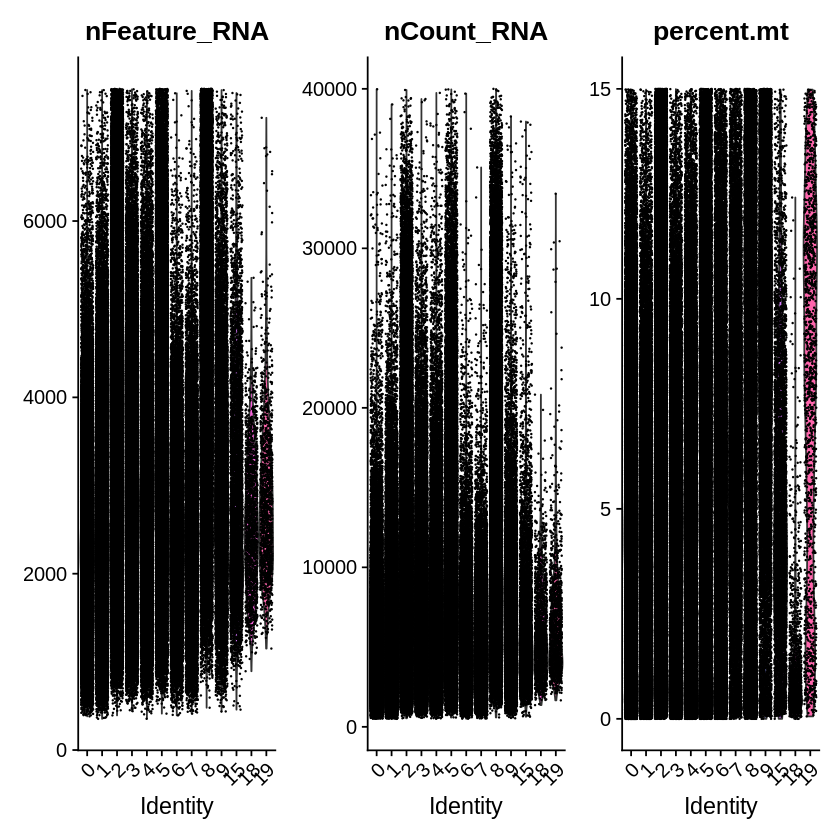

In [5]:
expr100[["percent.mt"]] <- PercentageFeatureSet(expr100, pattern = "^MT-")
VlnPlot(expr100, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [7]:
summary(expr100$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    354    2139    2866    3092    3822    7499 

In [8]:
summary(expr100$percent.mt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.866   4.549   5.019   7.398  15.000 

In [6]:
summary(expr100$nCount_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    501    4064    6216    7841    9721   39997 

In [11]:
head(expr100@meta.data)

orig.ident nCount_RNA nFeature_RNA lib.ident percent.mt
AAACAGCCAAGGTATA-1_1 2-0         8362      3569         2-0       0.9567089 
AAACAGCCAGGATGGC-1_1 2-0        12556      4490         2-0       0.4698949 
AAACAGCCAGTAAAGC-1_1 2-0         4688      2276         2-0       1.5784983 
AAACAGCCATGGCCTG-1_1 2-0        11856      4100         2-0       1.1049258 
AAACATGCAAGATTCT-1_1 2-0         4765      2402         2-0       0.4407135 
AAACATGCAAGCTACC-1_1 2-0        19262      5507         2-0       0.4724328 
                     nCount_SCT nFeature_SCT cell.line.ident time.ident
AAACAGCCAAGGTATA-1_1  9195      3569         CD_54           0hr       
AAACAGCCAGGATGGC-1_1 10661      4490         CD_54           0hr       
AAACAGCCAGTAAAGC-1_1  9479      2393         CD_54           0hr       
AAACAGCCATGGCCTG-1_1 10577      4100         CD_27           0hr       
AAACATGCAAGATTCT-1_1  9252      2505         CD_27           0hr       
AAACATGCAAGCTACC-1_1 10596      4780         CD_54           0hr       
                     integrated_snn_res.0.5 seurat_clusters fine.cell.type
AAACAGCCAAGGTATA-1_1 2                      2               NEFM+ glut    
AAACAGCCAGGATGGC-1_1 2                      2               NEFM+ glut    
AAACAGCCAGTAAAGC-1_1 4                      4               SEMA3E+ GABA  
AAACAGCCATGGCCTG-1_1 1                      1               NEFM- glut    
AAACATGCAAGATTCT-1_1 0                      0               GABA          
AAACATGCAAGCTACC-1_1 3                      3               NEFM- glut    
                     cell.type cell.type.forplot cell.type.counts  
AAACAGCCAAGGTATA-1_1 npglut    NEFM+ glut        NEFM+ glut\n159735
AAACAGCCAGGATGGC-1_1 npglut    NEFM+ glut        NEFM+ glut\n159735
AAACAGCCAGTAAAGC-1_1 GABA      GABA              GABA\n251501      
AAACAGCCATGGCCTG-1_1 nmglut    NEFM- glut        NEFM- glut\n137564
AAACATGCAAGATTCT-1_1 GABA      GABA              GABA\n251501      
AAACATGCAAGCTACC-1_1 nmglut    NEFM- glut        NEFM- glut\n137564
                     seq.batch.ident
AAACAGCCAAGGTATA-1_1 018            
AAACAGCCAGGATGGC-1_1 018            
AAACAGCCAGTAAAGC-1_1 018            
AAACAGCCATGGCCTG-1_1 018            
AAACATGCAAGATTCT-1_1 018            
AAACATGCAAGCTACC-1_1 018

In [13]:
expr100@meta.data <- expr100@meta.data[,c("orig.ident","nCount_RNA","nFeature_RNA","lib.ident","percent.mt","cell.line.ident",
                                         "time.ident","fine.cell.type","cell.type","seq.batch.ident")]
head(expr100@meta.data)

orig.ident nCount_RNA nFeature_RNA lib.ident percent.mt
AAACAGCCAAGGTATA-1_1 2-0         8362      3569         2-0       0.9567089 
AAACAGCCAGGATGGC-1_1 2-0        12556      4490         2-0       0.4698949 
AAACAGCCAGTAAAGC-1_1 2-0         4688      2276         2-0       1.5784983 
AAACAGCCATGGCCTG-1_1 2-0        11856      4100         2-0       1.1049258 
AAACATGCAAGATTCT-1_1 2-0         4765      2402         2-0       0.4407135 
AAACATGCAAGCTACC-1_1 2-0        19262      5507         2-0       0.4724328 
                     cell.line.ident time.ident fine.cell.type cell.type
AAACAGCCAAGGTATA-1_1 CD_54           0hr        NEFM+ glut     npglut   
AAACAGCCAGGATGGC-1_1 CD_54           0hr        NEFM+ glut     npglut   
AAACAGCCAGTAAAGC-1_1 CD_54           0hr        SEMA3E+ GABA   GABA     
AAACAGCCATGGCCTG-1_1 CD_27           0hr        NEFM- glut     nmglut   
AAACATGCAAGATTCT-1_1 CD_27           0hr        GABA           GABA     
AAACATGCAAGCTACC-1_1 CD_54           0hr        NEFM- glut     nmglut   
                     seq.batch.ident
AAACAGCCAAGGTATA-1_1 018            
AAACAGCCAGGATGGC-1_1 018            
AAACAGCCAGTAAAGC-1_1 018            
AAACAGCCATGGCCTG-1_1 018            
AAACATGCAAGATTCT-1_1 018            
AAACATGCAAGCTACC-1_1 018

In [ ]:
saveRDS(expr100, "100line_RNAonly_pctMT15_nCount500_4e4_nFeature_7500.rds")

In [13]:
summary(integrated_labeled$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    320    2094    2866    3078    3868    7499 

In [16]:
integrated_labeled@assays$integrated

Assay data with 3000 features for 651012 cells
Top 10 variable features:
 MTRNR2L6, COL1A1, MTRNR2L10, AC109466.1, SOX2-OT, CALCA, SST, FN1,
SPARC, COL1A2 

In [3]:
psbulk <- read.table("lme4_input_100lines/psbulk_100line_raw.txt", sep="\t")
head(psbulk)

Warning message in file(file, "rt"):
“cannot open file 'lme4_input_100lines/psbulk_100line_raw.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [3]:
summary(colSums(psbulk))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    6408  2303622  3953916  4781034  6017116 32063052 

In [6]:
meta = read.csv("mateqtl_input_100lines/100line_metadata_df.csv")
meta$cell_line[meta$cocul]

cell_line aff     sex age coculture_batch seq_batch time_point GABA_count
1   CD_22     case    M   53     23           25        0hr        1640      
2   CD_23     case    F   42     23           25        0hr        1397      
3   CD_25     control M   72      8           18        0hr         834      
4   CD_26     control M   43      8           18        0hr         874      
5   CD_27     control M   39      2           18        0hr        1881      
6   CD_36     case    M   57     21           25        0hr         238      
7   CD_37     control F   82     23           25        0hr        1050      
8   CD_38     case    M   22  20063           30        0hr         668      
9   CD_39     case    M   30  70305           30        0hr         277      
10  CD_40     control M   63     23           25        0hr        1081      
11  CD_42     case    F   46     39           22        0hr         665      
12  CD_43     control F   39     36           22        0hr         324      
13  CD_44     case    F   55     46           25        0hr         690      
14  CD_45     control M   56     17           25        0hr         399      
15  CD_46     case    F   64     46           25        0hr         430      
16  CD_47     control M   74     17           25        0hr         687      
17  CD_48     control F   72     21           25        0hr         524      
18  CD_49     case    F   31     49           22        0hr         703      
19  CD_54     control M   46      2           18        0hr         632      
20  CD_32     case    M   39     49           22        0hr         429      
21  CD_33     case    F   52     33           24        0hr        1074      
22  CD_34     case    M   55     33           24        0hr         911      
23  CD_31     control F   29     21           25        0hr         495      
24  CD_35     case    M   53     35           24        0hr        1488      
25  CD_50     case    M   49     35           24        0hr         619      
26  CD_51     case    M   48     51           24        0hr         209      
27  CD_55     control F   53     33           24        0hr         774      
28  CD_52     control M   47     33           24        0hr         410      
29  CD_56     control M   54     35           24        0hr        2231      
30  CD_53     control M   69     53           25        0hr         590      
⋮   ⋮         ⋮       ⋮   ⋮   ⋮               ⋮         ⋮          ⋮         
271 CW20087   control M   23  20087           29        6hr         831      
272 CW60134   control F   44  20087           29        6hr        1048      
273 CW70001   control M   56  20087           29        6hr         878      
274 CW70177   control F   70  20087           29        6hr         980      
275 CW60060   control F   37  60060           29        6hr         806      
276 CW70316   control M   49  60060           29        6hr         888      
277 CW70224   control M   57  60060           29        6hr         898      
278 CW70330   control F   60  60060           29        6hr        1183      
279 CW20077   control F   22  20088           29        6hr         693      
280 CW20088   control F   22  20088           29        6hr        1162      
281 CW20058   control M   25  20088           29        6hr        1050      
282 CW60109   control M   38  20088           29        6hr        1116      
283 CW50150   control F   65  50094           30        6hr         652      
284 CW70282   control M   66  50094           30        6hr         742      
285 CW50021   control F   69  50094           30        6hr         686      
286 CW50023   control M   69  50094           30        6hr         891      
287 CW50094   control M   70  50094           30        6hr         418      
288 CW20111   control M   28  20111           30        6hr         873      
289 CW70030   control M   60  20111           30        6hr         545      
290 CW50148   control F   

In [36]:
seq_batch <- meta[,c("cell_line","seq_batch")]
seq_batch <- seq_batch[!duplicated(seq_batch$cell_line),]
rownames(seq_batch) <- seq_batch$cell_line
seq_batch

cell_line seq_batch
CD_22   CD_22     25       
CD_23   CD_23     25       
CD_25   CD_25     18       
CD_26   CD_26     18       
CD_27   CD_27     18       
CD_36   CD_36     25       
CD_37   CD_37     25       
CD_38   CD_38     30       
CD_39   CD_39     30       
CD_40   CD_40     25       
CD_42   CD_42     22       
CD_43   CD_43     22       
CD_44   CD_44     25       
CD_45   CD_45     25       
CD_46   CD_46     25       
CD_47   CD_47     25       
CD_48   CD_48     25       
CD_49   CD_49     22       
CD_54   CD_54     18       
CD_32   CD_32     22       
CD_33   CD_33     24       
CD_34   CD_34     24       
CD_31   CD_31     25       
CD_35   CD_35     24       
CD_50   CD_50     24       
CD_51   CD_51     24       
CD_55   CD_55     24       
CD_52   CD_52     24       
CD_56   CD_56     24       
CD_53   CD_53     25       
⋮       ⋮         ⋮        
CW20087 CW20087   29       
CW60134 CW60134   29       
CW70001 CW70001   29       
CW70177 CW70177   29       
CW60060 CW60060   29       
CW70316 CW70316   29       
CW70224 CW70224   29       
CW70330 CW70330   29       
CW20077 CW20077   29       
CW20088 CW20088   29       
CW20058 CW20058   29       
CW60109 CW60109   29       
CW50150 CW50150   30       
CW70282 CW70282   30       
CW50021 CW50021   30       
CW50023 CW50023   30       
CW50094 CW50094   30       
CW20111 CW20111   30       
CW70030 CW70030   30       
CW50148 CW50148   30       
CW50059 CW50059   30       
CW50099 CW50099   30       
CW20063 CW20063   30       
CW20137 CW20137   30       
CW20079 CW20079   30       
CW20112 CW20112   30       
CW70305 CW70305   30       
CW70344 CW70344   30       
CW70079 CW70079   30       
CW50037 CW50037   30

In [15]:
table(meta$seq_batch)/3


18 22 24 25 29 30 
 5  5 15 28 24 23 

In [13]:
unique(meta$cell_line[meta$seq_batch==22])

[1] "CD_42" "CD_43" "CD_49" "CD_32" "CD_57"

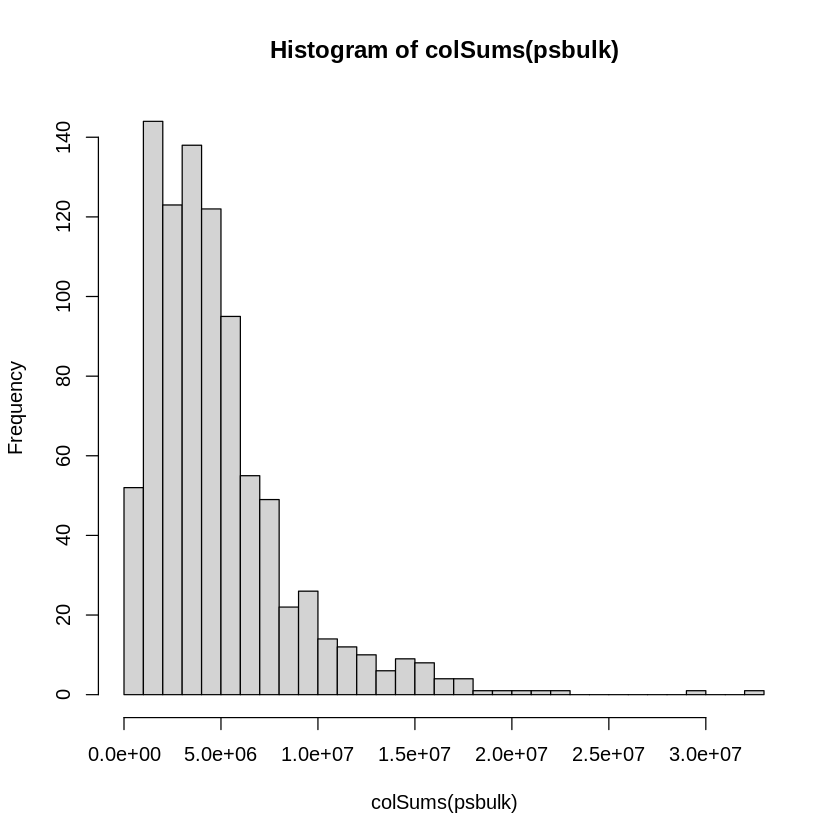

In [20]:
hist(colSums(psbulk), breaks = 30)

In [15]:
colnames(psbulk)[colSums(psbulk)<1e6]

[1] "CD_32_0hr_GABA"     "CD_36_0hr_GABA"     "CD_49_0hr_GABA"    
 [4] "CD_61_0hr_GABA"     "CD_63_0hr_GABA"     "CW30154_0hr_GABA"  
 [7] "CD_32_1hr_GABA"     "CD_61_1hr_GABA"     "CW30154_1hr_GABA"  
[10] "CW30154_6hr_GABA"   "CD_12_0hr_nmglut"   "CD_13_0hr_nmglut"  
[13] "CD_15_0hr_nmglut"   "CD_18_0hr_nmglut"   "CD_32_0hr_nmglut"  
[16] "CD_36_0hr_nmglut"   "CD_38_0hr_nmglut"   "CD_40_0hr_nmglut"  
[19] "CD_42_0hr_nmglut"   "CD_43_0hr_nmglut"   "CD_44_0hr_nmglut"  
[22] "CD_45_0hr_nmglut"   "CD_48_0hr_nmglut"   "CD_49_0hr_nmglut"  
[25] "CD_57_0hr_nmglut"   "CD_61_0hr_nmglut"   "CW50021_0hr_nmglut"
[28] "CD_32_1hr_nmglut"   "CD_40_1hr_nmglut"   "CD_43_1hr_nmglut"  
[31] "CD_44_1hr_nmglut"   "CD_45_1hr_nmglut"   "CD_49_1hr_nmglut"  
[34] "CD_57_1hr_nmglut"   "CW50021_1hr_nmglut" "CD_15_6hr_nmglut"  
[37] "CD_32_6hr_nmglut"   "CD_36_6hr_nmglut"   "CD_38_6hr_nmglut"  
[40] "CD_40_6hr_nmglut"   "CD_42_6hr_nmglut"   "CD_43_6hr_nmglut"  
[43] "CD_44_6hr_nmglut"   "CD_49_6hr_nmglut"   "CD_57_6hr_nmglut"  
[46] "CW50021_6hr_nmglut" "CW50150_6hr_nmglut" "CW70282_6hr_nmglut"
[49] "CD_32_0hr_npglut"   "CD_43_0hr_npglut"   "CD_49_0hr_npglut"  
[52] "CD_43_1hr_npglut"

In [16]:
# Filter out some genes and samples

psbulk1 <- psbulk[,colSums(psbulk)>1e6]
dim(psbulk1)

[1] 36601   848

In [24]:
sum(startsWith(colnames(psbulk1), "CD_42"))

[1] 7

In [18]:
table(meta$seq_batch[meta$cell_line %in% c()])

[1] "CD_42" "CD_43" "CD_49" "CD_32" "CD_57" "CD_42" "CD_43" "CD_49" "CD_32"
[10] "CD_57" "CD_42" "CD_43" "CD_49" "CD_32" "CD_57"

In [27]:
condition <- sapply(strsplit(colnames(psbulk1),"_"), function(x) {paste0(x[(length(x)-1):length(x)], collapse="_")})
table(condition)

condition
  0hr_GABA 0hr_nmglut 0hr_npglut   1hr_GABA 1hr_nmglut 1hr_npglut   6hr_GABA 
        94         83         97         97         92         99         99 
6hr_nmglut 6hr_npglut 
        87        100 

In [6]:
sample <- sapply(strsplit(colnames(psbulk1),"_"), function(x) {paste0(x[1:(length(x)-2)], collapse="_")})
table(sample)

sample
  CD_02   CD_03   CD_04   CD_05   CD_06   CD_07   CD_08   CD_09   CD_10   CD_11 
      9       9       9       9       9       9       9       9       9       9 
  CD_12   CD_13   CD_14   CD_15   CD_16   CD_17   CD_18   CD_19   CD_21   CD_22 
      8       8       9       7       9       9       8       9       9       9 
  CD_23   CD_25   CD_26   CD_27   CD_31   CD_32   CD_33   CD_34   CD_35   CD_36 
      9       9       9       9       9       3       9       9       9       6 
  CD_37   CD_38   CD_39   CD_40   CD_42   CD_43   CD_44   CD_45   CD_46   CD_47 
      9       7       9       6       7       4       6       7       9       9 
  CD_48   CD_49   CD_50   CD_51   CD_52   CD_53   CD_54   CD_55   CD_56   CD_57 
      8       4       9       9       9       9       9       9       9       6 
  CD_58   CD_60   CD_61   CD_62   CD_63   CD_64   CD_65   CD_66 CW20058 CW20063 
      9       9       6       9       8       9       9       9       9       9 
CW20077 CW20079 CW200

In [144]:
temp = psbulk1[,condition==co]
cell_names <- sapply(strsplit(colnames(temp), "_"), function(x) {ifelse(length(x)>3, paste0(x[1],"_",x[2]), x[1])})
ComBat_seq(temp, factor(seq_batch[cell_names,2]))

Found 6 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [7]:
colnames(psbulk1) <- paste(sample,condition,sep="|")

In [83]:
normalize <- function(mat) {
    temp <- calcNormFactors(mat, method = "TMM")
    mat.norm <- cpm(mat, normalized.lib.sizes = temp, log=T)
    
    mat.int = t(apply(mat.norm, 1, rank, ties.method = "average"))
    mat.int = qnorm(mat.int / (ncol(mat.norm)+1))
    
    scale(t(mat.int))
}

In [100]:
normalize1 <- function(mat) {
    temp <- calcNormFactors(mat, method = "TMM")
    mat.norm <- cpm(mat, normalized.lib.sizes = temp, log=T)
    
    mat.int = t(apply(mat.norm, 1, rank, ties.method = "average"))
    mat.int = qnorm(mat.int / (ncol(mat.norm)+1))
    
    mat.int <- scale(t(mat.int))
    cell_names <- sapply(strsplit(rownames(mat.int), "_"), function(x) {ifelse(length(x)>3, paste0(x[1],"_",x[2]), x[1])})
    mat.bat <- ComBat(t(mat.int), factor(seq_batch[cell_names,2]))
}

In [141]:
normalize2 <- function(mat) {
    temp <- calcNormFactors(mat, method = "TMM")
    mat.norm <- cpm(mat, normalized.lib.sizes = temp, log=T)
    
    cell_names <- sapply(strsplit(colnames(mat.norm), "_"), function(x) {ifelse(length(x)>3, paste0(x[1],"_",x[2]), x[1])})
    mat.bat <- ComBat(mat.norm, factor(seq_batch[cell_names,2]))
    mat.bat
    #print(dim(mat.bat))
    mat.int = t(apply(mat.bat, 1, rank, ties.method = "average"))
    mat.int = qnorm(mat.int / (ncol(mat.norm)+1))
    #scale(t(mat.int))
}

In [101]:
### Normalize each condition seperately
expr.norm <- list()
for (co in unique(condition)) {
    expr.norm[[co]] <- normalize1(psbulk1[,condition == co])
}
sapply(expr.norm, length)

Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 8148 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found5batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Using the 'mean only' version of ComBat

Found6batches

Note: one batch has only one sample, setting mean.only=TRUE

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found5batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 13271 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 5018 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




0hr_GABA   1hr_GABA   6hr_GABA 0hr_nmglut 1hr_nmglut 6hr_nmglut 0hr_npglut 
   3440494    3550297    3623499    3037883    3367292    3184287    3550297 
1hr_npglut 6hr_npglut 
   3623499    3660100

In [142]:
### Normalize each condition seperately
expr.norm2 <- list()
for (co in unique(condition)) {
    expr.norm2[[co]] <- normalize2(psbulk1[,condition == co])
}
sapply(expr.norm2, nrow)

Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 8148 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found5batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Using the 'mean only' version of ComBat

Found6batches

Note: one batch has only one sample, setting mean.only=TRUE

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found5batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 13271 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 5018 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found6batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




0hr_GABA   1hr_GABA   6hr_GABA 0hr_nmglut 1hr_nmglut 6hr_nmglut 0hr_npglut 
     36601      36601      36601      36601      36601      36601      36601 
1hr_npglut 6hr_npglut 
     36601      36601

In [151]:
expr <- read.table("mateqtl_input_100lines/expr_0hr_GABA.txt", header=T, row.names=1)
genes <- unique(sapply(strsplit(rownames(expr),"\\."), function(x) x[1])) # Drop duplicate gene name with version suffix
expr.norm4 <- lapply(expr.norm2, function(x) {x[genes,]})
expr.norm3 <- lapply(expr.norm, function(x) {x[genes,]})
saveRDS(expr.norm4, "mateqtl_input_100lines/expr_TMM_combat_Qnorm.rds")
saveRDS(expr.norm3, "mateqtl_input_100lines/expr_TMM_Qnorm_combat.rds")

In [150]:
covar <- as.matrix(read.table(paste0("mateqtl_input_100lines/covar_6hr_GABA.txt"), header=T, row.names=1))

[1] 36601    97

In [54]:
### Normalize each condition seperately with TMM only
expr.tmm <- list()
for (co in unique(condition)) {
    expr.tmm[[co]] <- tmm(psbulk1[,condition == co])
}
sapply(expr.tmm, nrow)

0hr_GABA   1hr_GABA   6hr_GABA 0hr_nmglut 1hr_nmglut 6hr_nmglut 0hr_npglut 
     36601      36601      36601      36601      36601      36601      36601 
1hr_npglut 6hr_npglut 
     36601      36601

In [129]:
sum(is.na(expr.norm2[[1]]))

[1] 3434454

In [90]:
cell_names <- sapply(strsplit(rownames(expr.norm[[3]]), "_"), function(x) {ifelse(length(x)>3, paste0(x[1],"_",x[2]), x[1])})

ERROR: Error in expr.norm[[3]]: subscript out of bounds


In [89]:
cell_names <- sapply(strsplit(rownames(expr.norm[[3]]), "_"), function(x) {ifelse(length(x)>3, paste0(x[1],"_",x[2]), x[1])})
GABA6.cblast <- ComBat(t(expr.norm[[3]]), batch = factor(seq_batch[cell_names,2]))

ERROR: Error in expr.norm[[3]]: subscript out of bounds


In [9]:
GABA0v1 <- normalize(psbulk1[,condition %in% c("0hr_GABA", "1hr_GABA")])
GABA0v6 <- normalize(psbulk1[,condition %in% c("0hr_GABA", "6hr_GABA")])
head(GABA0v1)

MIR1302-2HG FAM138A    OR4F5      AL627309.1 AL627309.3
CD_02|0hr_GABA  0.05236083  0.3505462  0.2382014  0.5449585 -0.144472 
CD_03|0hr_GABA  2.63333671  0.3505462  0.2382014 -0.2563938 -0.144472 
CD_04|0hr_GABA -2.14054780 -2.8377552 -2.5892395 -1.0549486 -2.176340 
CD_05|0hr_GABA  0.05236083  0.3505462  0.2382014  0.3114439 -0.144472 
CD_06|0hr_GABA  0.05236083  0.3505462  0.2382014  0.3254518 -0.144472 
CD_07|0hr_GABA  2.20283202  0.3505462  0.2382014  0.2974943 -0.144472 
               AL627309.2 AL627309.5  AL627309.4   AP006222.2 AL732372.1 ⋯
CD_02|0hr_GABA  0.3081909 -0.18774925 -0.732131984 -0.2382624  0.2754325 ⋯
CD_03|0hr_GABA  4.5851228 -0.74006284 -0.732131984 -0.2382624  0.2754325 ⋯
CD_04|0hr_GABA -2.6985424 -1.14955868 -2.048393406 -2.1969164 -2.6018729 ⋯
CD_05|0hr_GABA  0.3081909 -0.96710019 -0.097374562 -0.2382624  0.2754325 ⋯
CD_06|0hr_GABA  0.3081909 -1.17503648  0.274953723 -0.2382624  0.2754325 ⋯
CD_07|0hr_GABA  0.3081909  0.01333591  0.001876703  2.6030906  0.2754325 ⋯
               AC133551.1 AC136612.1 AC136616.1 AC136616.3 AC136616.2
CD_02|0hr_GABA  0.3505462  0.3505462 -0.7071526  0.3081909  0.2754325
CD_03|0hr_GABA  0.3505462  0.3505462  0.3950264  0.3081909  0.2754325
CD_04|0hr_GABA -2.8377552 -2.8377552  1.6501860 -2.6985424 -2.6018729
CD_05|0hr_GABA  0.3505462  0.3505462  0.5706939  0.3081909  0.2754325
CD_06|0hr_GABA  0.3505462  0.3505462  0.3491347  0.3081909  0.2754325
CD_07|0hr_GABA  0.3505462  0.3505462 -0.7071526  0.3081909  0.2754325
               AC141272.1 AC023491.2 AC007325.1 AC007325.4 AC007325.2
CD_02|0hr_GABA  0.3505462 0.1245686   0.3081909 -1.7119063 -0.2247572
CD_03|0hr_GABA  0.3505462 0.1245686   0.3081909 -0.3678585  1.7259013
CD_04|0hr_GABA -2.8377552 3.3519915  -2.6985424  1.0316651  1.5239053
CD_05|0hr_GABA  0.3505462 0.1245686   0.3081909 -1.4856200 -0.2247572
CD_06|0hr_GABA  0.3505462 0.1245686   0.3081909 -0.5295435 -0.2247572
CD_07|0hr_GABA  0.3505462 0.1245686   0.3081909  0.1202973  2.1361248

In [23]:
# Use the same set of genes

expr <- read.table("mateqtl_input_100lines/expr_0hr_GABA.txt", header=T, row.names=1)
genes <- unique(sapply(strsplit(rownames(expr),"\\."), function(x) x[1])) # Drop duplicate gene name with version suffix
                
GABA0v1.sub <- GABA0v1[,genes]
GABA0v6.sub <- GABA0v6[,genes]

saveRDS(GABA0v1.sub, "mateqtt100_interaction_input/expr_GABA_1hr_vs_0hr.rds")
saveRDS(GABA0v6.sub, "mateqtt100_interaction_input/expr_GABA_6hr_vs_0hr.rds")

In [13]:
expr <- read.table("mateqtl_input_100lines/expr_0hr_GABA.txt", header=T, row.names=1)
rownames(expr)[!(rownames(expr) %in% colnames(GABA0v1))]

[1] "ADI1.1"         "AKT3.1"         "ASAP3.1"        "ATP5IF1.1"     
   [5] "B3GALNT2.1"     "CEP170.1"       "CLK2.1"         "CRIM1.1"       
   [9] "CRIM1-DT.1"     "DNAJC8.1"       "FOXO6.1"        "GATAD2B.1"     
  [13] "GNG4.1"         "HCN3.1"         "HHAT.1"         "HNRNPR.1"      
  [17] "ID3.1"          "INTS3.1"        "KIF26B.1"       "LINC01355.1"   
  [21] "LRIG2-DT.1"     "MED18.1"        "MMEL1.1"        "PANK4.1"       
  [25] "PLCH2.1"        "PRXL2B.1"       "RCC2.1"         "RHOU.1"        
  [29] "RNF187.1"       "RPS6KA1.1"      "SCAMP3.1"       "SDCCAG8.1"     
  [33] "SERTAD4.1"      "SERTAD4-AS1.1"  "SESN2.1"        "SLC16A1.1"     
  [37] "SLC25A24.1"     "SLC27A3.1"      "SNTG2.1"        "SNTG2.2"       
  [41] "TBCE.2"         "TCEA3.1"        "TPO.1"          "TRAPPC12.1"    
  [45] "TRIM17.1"       "ZNF436.1"       "ZNF436-AS1.1"   "ARHGEF26.1"    
  [49] "ARHGEF26-AS1.1" "ATG16L1.1"      "BDH1.1"         "C3orf52.1"     
  [53] "CPEB2-DT.1"     "CTSO.1"         "DCHS2.1"        "DGKD.1"        
  [57] "DHX36.1"        "EEF1B2.1"       "EEFSEC.1"       "FAM240C.1"     
  [61] "HERC3.1"        "INO80D.1"       "INPP5D.1"       "KCNIP4.1"      
  [65] "KIAA1143.1"     "KIF15.1"        "KIF5C.1"        "LINC01237.1"   
  [69] "LINC01238.2"    "LINC01238.3"    "LINC02018.1"    "LINC02054.1"   
  [73] "MAGI1.1"        "MUC20.1"        "MUC20.2"        "MUC20.3"       
  [77] "MUC20.4"        "MUC20.5"        "MUC20.6"        "MUC20.7"       
  [81] "MUC4.1"         "MUC4.2"         "MUC4.3"         "MUC4.4"        
  [85] "MUC4.5"         "MUC4.6"         "MUC4.7"         "NDUFS1.1"      
  [89] "NOSTRIN.1"      "PLCL2.1"        "PLEKHM3.1"      "RUVBL1.1"      
  [93] "RYBP.1"         "SLC25A26.1"     "SLC9C1.1"       "SPC25.1"       
  [97] "TAMM41.1"       "TBILA.1"        "TMEM42.1"       "YTHDC1.1"      
 [101] "ZDBF2.1"        "ZKSCAN7.1"      "ZKSCAN7-AS1.1"  "ZNF197.1"      
 [105] "ZNF35.1"        "ZNF445.1"       "ZNF501.1"       "ZNF502.1"      
 [109] "ZNF660.1"       "ZNF852.1"       "ABCF1.1"        "ABCF1.2"       
 [113] "ABCF1.3"        "ABCF1.4"        "ABCF1.5"        "ABCF1.6"       
 [117] "ABHD16A.1"      "ABHD16A.2"      "ABHD16A.3"      "ABHD16A.4"     
 [121] "ABHD16A.5"      "ABHD16A.6"      "ADAMTS2.1"      "AGER.1"        
 [125] "AGER.2"         "AGER.3"         "AGER.4"         "AGER.5"        
 [129] "AGER.6"         "AGPAT1.1"       "AGPAT1.2"       "AGPAT1.3"      
 [133] "AGPAT1.4"       "AGPAT1.5"       "AGPAT1.6"       "AK6.1"         
 [137] "APOM.1"         "APOM.2"         "APOM.3"         "APOM.4"        
 [141] "APOM.5"         "APOM.6"         "ATAT1.1"        "ATAT1.2"       
 [145] "ATAT1.3"        "ATAT1.4"        "ATAT1.5"        "ATAT1.6"       
 [149] "ATF6B.1"        "ATF6B.2"        "ATF6B.3"        "ATP6V1G2.1"    
 [153] "ATP6V1G2.2"     "ATP6V1G2.3"     "ATP6V1G2.4"     "ATP6V1G2.5"    
 [157] "ATP6V1G2.6"     "B3GALT4.1"      "B3GALT4.2"      "B3GALT4.3"     
 [161] "B3GALT4.4"      "BAG6.1"         "BAG6.2"         "BAG6.3"        
 [165] "BAG6.4"         "BAG6.5"         "BAG6.6"         "BDP1.1"        
 [169] "BDP1.2"         "BRD2.1"         "BRD2.2"         "BRD2.3"        
 [173] "BRD2.4"         "BRD2.5"         "BRD2.6"         "C2.1"          
 [177] "C2.2"           "C2.3"           "C2.4"           "C2.5"          
 [181] "C2.6"           "C6orf136.1"     "C6orf136.2"     "C6orf136.3"    
 [185] "C6orf136.4"     "C6orf136.5"     "C6orf136.6"     "C6orf47.1"     
 [189] "C6orf47.2"      "C6orf47.3"      "C6orf47.4"      "C6orf47.5"     
 [193] "C6orf47.6"      "C6orf52.1"      "CANX.1"         "CASP8AP2.1"    
 [197] "CCDC125.1"      "CCHCR1.1"       "CCHCR1.2"       "CCHCR1.3"      
 [201] "CCHCR1.4"       "CCHCR1.5"       "CDK7.1"         "CEP72.1"       
 [205] "CLIC1.1"        "CLIC1.2"        "CLIC1.3"        "CLIC1.4"       
 [209] "CLIC1.5"        "CLIC1.6"        "CLPTM1L.1"      "COL11A2.1"     
 [213] "COL11A2.2"      "COL

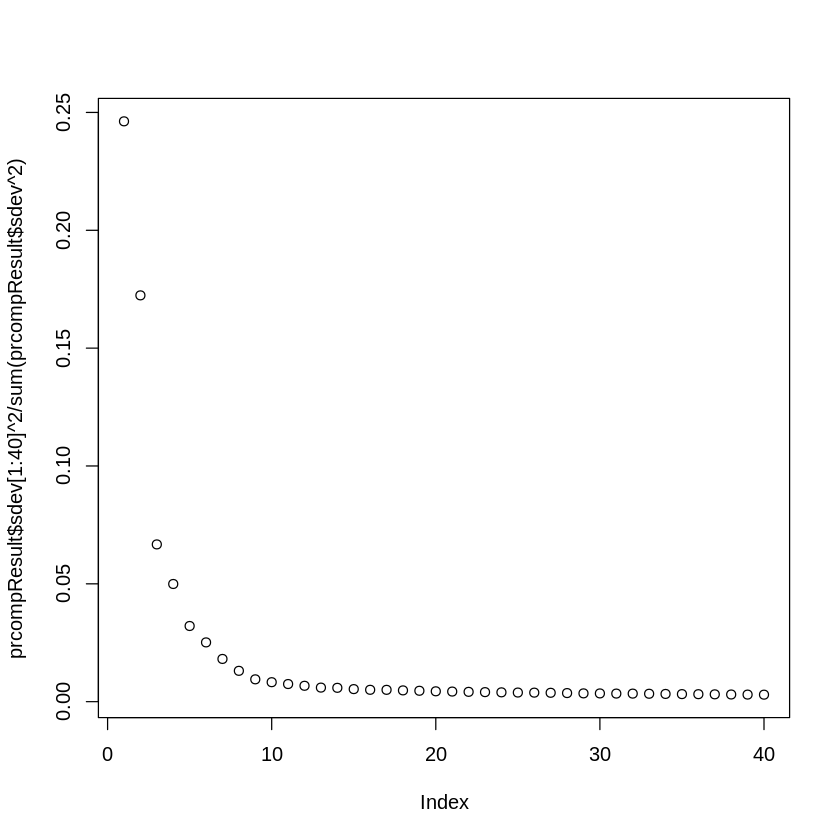

In [28]:
prcompResult <- prcomp(GABA0v6.sub,center=TRUE,scale.=TRUE)
PCs <- prcompResult$x
saveRDS(PCs[,1:40],"GABA0v6_expr_PC40.RDS")
plot(prcompResult$sdev[1:40]^2/sum(prcompResult$sdev^2))

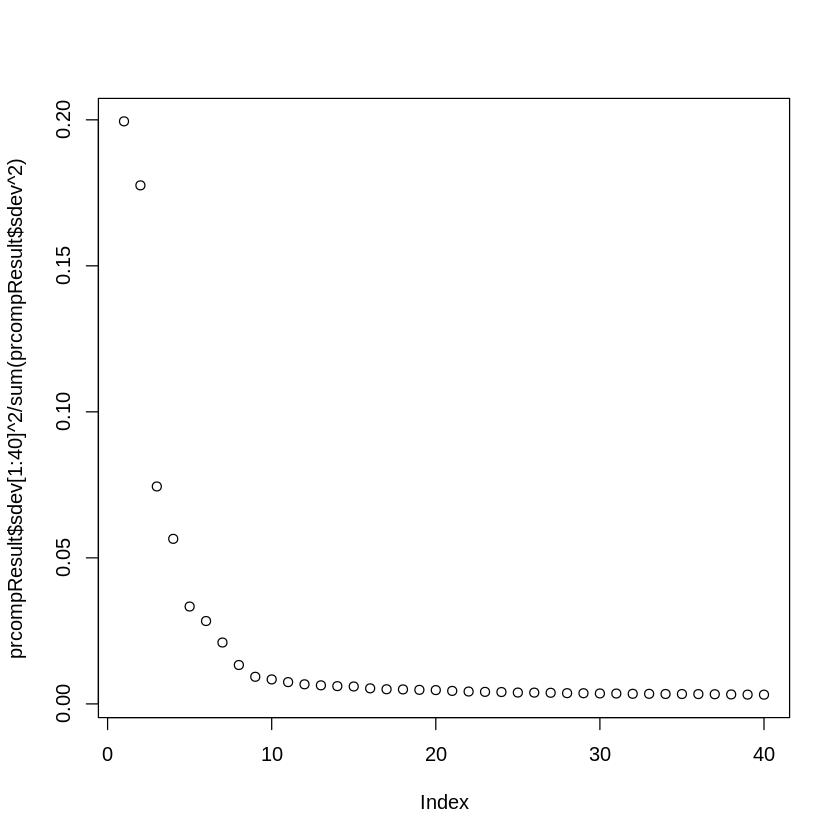

In [29]:
prcompResult <- prcomp(GABA0v1.sub,center=TRUE,scale.=TRUE)
PCs <- prcompResult$x
saveRDS(PCs[,1:40],"GABA0v1_expr_PC40.RDS")
plot(prcompResult$sdev[1:40]^2/sum(prcompResult$sdev^2))

In [27]:
head(PCs)

PC1       PC2       PC3      PC4       PC5        PC6       
CD_02|0hr_GABA -61.25483  24.28905 47.41970  36.19350 -0.8828388 -16.562272
CD_03|0hr_GABA -50.47735 -16.42450 27.72506 -40.64044  6.7827177  -3.517901
CD_04|0hr_GABA -22.52366 -52.57721 26.61098  37.16193 -5.8267322 -28.884703
CD_05|0hr_GABA -62.38600  17.60116 46.57268  31.40197 -9.4254435 -15.423538
CD_06|0hr_GABA -66.45216  23.68665 41.72650  31.22919 -1.0598576 -16.208550
CD_07|0hr_GABA -48.25431 -22.53563 39.42438 -47.79465 -6.4365506 -12.915960
               PC7        PC8       PC9        PC10      ⋯ PC182     
CD_02|0hr_GABA  -3.674030  1.729883  -1.002153  2.720326 ⋯ -0.2170670
CD_03|0hr_GABA  -2.718527 26.617647 -16.206709 28.470343 ⋯  0.3772801
CD_04|0hr_GABA -23.294743  9.520222  -6.255517 -1.067074 ⋯ -0.6454121
CD_05|0hr_GABA  -7.674815  6.472699  -4.923992  9.061153 ⋯  3.5583010
CD_06|0hr_GABA -11.624143  8.510976   1.005219 11.626628 ⋯ -2.7210824
CD_07|0hr_GABA  10.932383 28.819388 -11.866510 15.845717 ⋯ -0.5023896
               PC183      PC184      PC185      PC186      PC187     
CD_02|0hr_GABA  0.1539522 -1.0502514 -0.7137954  0.4391536 -0.9198929
CD_03|0hr_GABA  0.1522093  1.8033777 -0.7256240  0.2048955 -0.6995076
CD_04|0hr_GABA  1.3631481 -0.2031516 -0.1323627 -0.3284341 -0.8936590
CD_05|0hr_GABA -1.8003314  1.6045178 -4.1604957 -5.7572576 22.8858475
CD_06|0hr_GABA -0.5304957  0.5266785  0.5914002  1.4761000 -2.6391393
CD_07|0hr_GABA -0.4752496 -0.2917337 -0.5375920  0.4819167 -1.0632486
               PC188        PC189       PC190       PC191        
CD_02|0hr_GABA   0.87598724 -0.19381274 -0.16442075 -1.526557e-16
CD_03|0hr_GABA  -0.33594745 -0.05122174 -0.27580387  2.291223e-14
CD_04|0hr_GABA  -0.03248331 -0.64346030  0.25023052 -9.874046e-15
CD_05|0hr_GABA -12.32976518  0.88818690  0.57582163 -2.207262e-14
CD_06|0hr_GABA   1.99012986  0.23403433 -0.09999772  1.046940e-13
CD_07|0hr_GABA   0.24039258  0.15875194  0.16580286 -6.188453e-14

In [26]:
psbulk.cond <- list()
pca.res <- list()
pc.cond <- list()
for(c in unique(condition)) {
    psbulk.cond[[c]] <- normalize(psbulk1[, condition==c])
    pca.res[[c]] <- prcomp(psbulk.cond[[c]],center=TRUE,scale.=TRUE)
    pc.cond[[c]] <- prcompResult$x
}

In [27]:
psbulk.cond[[1]]

AL627309.1  AL627309.5  AL627309.4 AL669831.2  LINC01409  
CD_02_0hr_GABA    0.46714645 -0.01368878 -0.4214456 -1.01381099  0.17883051
CD_03_0hr_GABA   -0.23541902 -0.62431225 -0.4214456  0.43681443 -1.79162985
CD_04_0hr_GABA   -0.87474976 -1.13573859 -0.4214456 -1.01381099  0.49751903
CD_05_0hr_GABA    0.23453231 -0.87323804  0.3506069 -0.25319945 -0.26286448
CD_06_0hr_GABA    0.26274273 -1.18695626  0.7221828  0.40626046 -0.34866193
CD_07_0hr_GABA    0.20649414  0.23468853  0.4789745  0.03012386 -0.23468853
CD_08_0hr_GABA   -0.20738085 -0.91288992 -0.4214456 -1.01381099  1.36143017
CD_09_0hr_GABA    0.49768436 -0.99650332 -0.4214456  1.32269014 -0.62431225
CD_10_0hr_GABA    0.72627077 -0.23468853 -0.4214456 -0.49189766 -0.43691622
CD_11_0hr_GABA    1.68232158  0.15110470  1.0070625 -0.02614195  0.79751828
CD_12_0hr_GABA   -0.65869137  0.76121782  2.5686303  1.38666991  0.20668463
CD_13_0hr_GABA    0.95464584  0.49751903  1.1515578  1.61762590 -0.29123565
CD_14_0hr_GABA   -0.59297299 -0.59180559  1.3814992  0.69812942  0.37776945
CD_15_0hr_GABA    0.34864515 -1.04083278 -0.4214456  1.82866166 -1.50331936
CD_16_0hr_GABA    1.24231760 -1.50331936  1.3186855  2.15455796  1.79162985
CD_17_0hr_GABA   -2.23362909 -0.76121782 -0.4214456  0.46774176  0.23468853
CD_18_0hr_GABA   -0.69254857 -0.04107589 -0.4214456  1.26318768 -0.91288992
CD_19_0hr_GABA   -1.68320829 -2.39370677  1.0532454  1.01174018  0.12348639
CD_21_0hr_GABA   -0.12408083  0.52845580 -1.7973445 -1.99280230 -2.10883145
CD_22_0hr_GABA    0.59208627  0.87323804  2.0634018  0.88509612 -1.08714854
CD_23_0hr_GABA   -0.34953186 -0.79751828  0.7980585 -0.16732453  0.29123565
CD_25_0hr_GABA   -0.91445015 -0.72582611 -1.7973445  0.17165443  1.18695626
CD_26_0hr_GABA   -1.79426518 -0.29123565 -0.4214456 -0.37029693  1.08714854
CD_27_0hr_GABA    0.62463271 -0.31982631 -1.7973445 -0.55501907  0.69125949
CD_31_0hr_GABA    0.04068279  1.79162985  1.6928476 -1.01381099  1.24124236
CD_33_0hr_GABA   -0.40811893  1.04083278  0.4140718 -0.34067090  0.06849165
CD_34_0hr_GABA    0.17860595  0.17883051 -0.4214456 -0.13894919  0.62431225
CD_35_0hr_GABA   -0.04156950  0.26286448  0.3821764 -1.99280230  0.09595532
CD_37_0hr_GABA    0.37778828 -0.52845580 -0.4214456  1.20741357  2.39370677
CD_38_0hr_GABA   -0.62551942  1.36143017  0.5456085  0.66338668  1.42903525
⋮                ⋮           ⋮           ⋮          ⋮           ⋮          
CW30274_0hr_GABA  1.13668475  0.12348639 -0.4214456  0.73364353 -0.15110470
CW30454_0hr_GABA  1.50471525 -0.65744367 -0.4214456 -1.01381099 -1.04083278
CW30525_0hr_GABA  0.56011137 -0.15110470 -0.4214456  0.84562737 -0.01368878
CW40201_0hr_GABA -0.99816585 -1.42903525 -0.4214456  0.49907840 -0.49751903
CW50021_0hr_GABA  1.79337847  0.69125949 -0.4214456  0.80730083 -0.09595532
CW50023_0hr_GABA -1.36353916 -0.43691622  0.5120549  0.08650757 -0.69125949
CW50037_0hr_GABA -0.17949266 -1.36143017  0.8778887  0.53086317  1.50331936
CW50040_0hr_GABA  1.08803526 -0.40717741 -0.4214456 -1.01381099 -1.29915733
CW50059_0hr_GABA -1.24320431  0.01368878 -0.4214456  0.34614104 -0.40717741
CW50094_0hr_GABA -1.08892197  1.29915733 -0.4214456 -1.01381099  0.72582611
CW50099_0hr_GABA -1.93068192 -0.49751903  1.5223628 -0.43041636  0.59180559
CW50148_0hr_GABA -0.52954570  0.83482229 -0.4214456  0.20027204 -0.55986976
CW50150_0hr_GABA  1.58772170 -0.20668463  0.7596732 -1.01381099  2.10883145
CW50166_0hr_GABA  0.79805065 -1.68070867 -0.4214456 -1.01381099  1.58622439
CW60060_0hr_GABA  0.76170578  1.13573859 -0.4214456 -1.01381099 -1.92787990
CW60109_0hr_GABA  0.29114861 -0.46701843 -1.7973445  0.14316863 -0.95392212
CW60134_0hr_GABA -0.15173293  0.99650332 -0.4214456  0.05829110 -0.31982631
CW70001_0hr_GABA  0.65780466  0.55986976 -0.4214456  0.11479329  0.04107589
CW70030_0hr_GABA  0.87386305  1.50331936 -1.7973445  0.31651501 -1.18695626
CW70079_0hr_GABA  0.40723222 -0.55986976  0.9625597  0.77000535 -0.12348639
CW70142_0hr_GABA -1.18885180 -0.34866193 -0.4214456 -1.01381099 -

In [29]:
saveRDS(list(expr=psbulk.cond, pca.res=pca.res, pc.cond=pc.cond), "seperate_expr.rds")

In [7]:
### TMM normalization

temp <- calcNormFactors(psbulk1, method = "TMM")
psbulk.norm <- cpm(psbulk1, normalized.lib.sizes = temp, log=T)
head(psbulk.norm)

CD_02_0hr_GABA CD_03_0hr_GABA CD_04_0hr_GABA CD_05_0hr_GABA
AL627309.1  0.9068201      0.4747775      0.01758889     0.8317077    
AL627309.5  1.3820486      1.0861118      0.85811900     0.9565861    
AL627309.4 -1.2794203     -1.2794203     -1.27942029    -1.0220341    
AL669831.2 -1.2794203     -0.1506693     -1.27942029    -0.6140880    
LINC01409   4.0124476      3.4492571      4.10605592     3.8810718    
LINC01128   4.5290492      4.7578475      4.90818952     4.7529601    
           CD_06_0hr_GABA CD_07_0hr_GABA CD_08_0hr_GABA CD_09_0hr_GABA
AL627309.1  0.8432910      0.8304415      0.5142081      0.9073049    
AL627309.5  0.8432910      1.4869361      0.9533282      0.9073049    
AL627309.4 -0.6386272     -0.7790645     -1.2794203     -1.2794203    
AL669831.2 -0.1964642     -0.4082668     -1.2794203      0.1937714    
LINC01409   3.8544042      3.8834037      4.3383400      3.8021986    
LINC01128   5.0795733      4.7758808      4.3741312      4.4832110    
           CD_10_0hr_GABA CD_11_0hr_GABA ⋯ CW70142_6hr_npglut
AL627309.1  1.0132213      1.4482439     ⋯  1.38963839       
AL627309.5  1.2750225      1.4482439     ⋯  2.08943399       
AL627309.4 -1.2794203     -0.5113606     ⋯ -0.02261123       
AL669831.2 -0.8734711     -0.5113606     ⋯ -0.79703926       
LINC01409   3.8414241      4.1761256     ⋯  3.42179550       
LINC01128   4.6994029      4.4102817     ⋯  5.58034759       
           CW70177_6hr_npglut CW70179_6hr_npglut CW70224_6hr_npglut
AL627309.1  1.0983325          1.9611649          2.007672         
AL627309.5  2.1526866          2.1140297          2.257371         
AL627309.4 -0.3287834         -1.0028708         -0.732338         
AL669831.2 -0.7271781         -0.5711155         -0.732338         
LINC01409   4.0148974          3.2021842          3.440969         
LINC01128   5.4789823          5.4743306          5.088992         
           CW70282_6hr_npglut CW70305_6hr_npglut CW70316_6hr_npglut
AL627309.1  1.257262           2.03789727         1.0353479        
AL627309.5  1.443691           1.67031444         2.0344504        
AL627309.4  0.306049          -0.04970072        -0.5460302        
AL669831.2 -1.279420          -0.35584563        -1.2794203        
LINC01409   3.432806           3.35083647         3.1931532        
LINC01128   5.203534           5.36584084         4.8614979        
           CW70330_6hr_npglut CW70344_6hr_npglut CW70372_6hr_npglut
AL627309.1  1.9663514          1.7516794          2.006760         
AL627309.5  1.7690872          1.8791619          1.519880         
AL627309.4 -1.2794203          0.2506406         -0.476087         
AL669831.2 -0.1338998         -0.4677913         -1.032973         
LINC01409   3.0708045          3.0876009          3.499422         
LINC01128   5.0820212          5.3957710          5.471985

In [8]:
### Minus average expression 

condition <- sapply(strsplit(colnames(psbulk.norm),"_"), function(x) {paste0(x[(length(x)-1):length(x)], collapse="_")})
cond.mean <- aggregate(t(psbulk.norm), by=list(condition), FUN = mean)
psbulk.condmean <- psbulk.norm

for(i in 1:9) {
    psbulk.condmean[, endsWith(colnames(psbulk.condmean),cond.mean[i,1])] <- psbulk.condmean[, endsWith(colnames(psbulk.condmean),cond.mean[i,1])] - as.numeric(cond.mean[i,-1])
}

In [9]:
aggregate(t(psbulk.condmean), by=list(condition), FUN = mean)

Group.1    AL627309.1    AL627309.5    AL627309.4    AL669831.2   
1 0hr_GABA   -4.709065e-17  6.713224e-18  2.805181e-17 -3.633172e-18
2 0hr_nmglut -2.502175e-17 -1.038529e-16 -5.887334e-18  1.225863e-17
3 0hr_npglut -3.251730e-17  5.271454e-17  5.436014e-17 -1.135948e-18
4 1hr_GABA    7.298652e-18  8.858096e-17 -2.578211e-17 -4.934750e-17
5 1hr_nmglut -3.661152e-17  9.143848e-17 -3.542044e-17  2.346795e-17
6 1hr_npglut  5.660511e-17 -5.106809e-17  2.243419e-17 -2.888938e-17
7 6hr_GABA    1.083107e-18  5.385090e-17  5.386021e-17  1.850262e-17
8 6hr_nmglut -5.093669e-17  4.513676e-18 -2.569450e-17  1.060656e-17
9 6hr_npglut  5.102147e-17  4.997738e-17 -1.530589e-17  5.004677e-18
  LINC01409     LINC01128     LINC00115     FAM41C        AL645608.6    ⋯
1 -2.018464e-16 -1.076547e-16  3.479468e-17 -6.634441e-18  3.809588e-17 ⋯
2 -3.103758e-16  2.769717e-16  5.491426e-17 -3.156497e-17  6.446739e-17 ⋯
3  1.256163e-16 -2.601580e-16 -1.009086e-16 -2.106638e-17  6.283992e-17 ⋯
4 -2.693038e-17 -3.678323e-16  4.711899e-17 -1.458635e-17 -1.449874e-17 ⋯
5 -1.602452e-16 -2.838569e-16  9.500741e-17 -2.832283e-17  3.435971e-17 ⋯
6 -1.642913e-16  1.865238e-16  5.224662e-17  2.245383e-18  4.989498e-17 ⋯
7 -1.794366e-16 -3.498927e-16  6.047162e-17 -4.076710e-19 -6.279830e-17 ⋯
8  1.211217e-16 -2.242204e-17 -4.505736e-18  3.642481e-18 -2.154102e-16 ⋯
9 -2.175462e-16  2.931019e-16  5.775599e-17 -5.512626e-18 -1.883259e-17 ⋯
  MT-ND5        MT-ND6        MT-CYB        AC011043.1    AL354822.1   
1  6.100637e-16 -2.870798e-16 -3.947769e-16 -8.968159e-17 -1.676667e-17
2 -6.112015e-16 -3.341977e-16  4.584243e-16  7.169578e-18 -3.403841e-17
3 -7.356494e-16 -5.384980e-17  4.844803e-16 -1.525226e-16  4.877815e-17
4  1.077095e-16  1.839368e-16  8.073807e-16 -9.197429e-17 -5.270865e-17
5  7.783163e-16  2.014425e-16 -1.098550e-16 -4.805195e-17  5.380046e-17
6  2.042948e-16  3.551602e-17  1.065118e-16  8.877881e-17  2.832139e-17
7 -6.369654e-16  8.075198e-17 -8.433130e-16 -1.793687e-16 -4.204076e-17
8 -4.934214e-16 -2.377751e-16  3.767968e-16  8.523995e-17 -9.527399e-17
9 -4.973452e-16  2.620186e-16  3.553380e-16 -1.265595e-16 -3.051650e-17
  AL592183.1    AC240274.1    AC004556.3    AC136616.1    AC007325.4   
1 -4.564327e-18 -7.850493e-17  2.188117e-17  3.767219e-17  1.119028e-17
2  2.101930e-16 -3.582181e-17  4.084411e-17  4.825749e-17  5.369948e-17
3 -6.717235e-17  1.323411e-16  4.085361e-17 -3.306269e-18  4.383202e-17
4  4.126014e-16  6.503461e-17  1.033825e-18  2.070566e-17 -9.415283e-17
5  1.144303e-16 -7.557448e-17 -1.366989e-17  4.869185e-17 -2.736954e-17
6 -8.001602e-17 -9.770179e-17 -3.359292e-17 -2.373515e-17  5.712390e-18
7  2.235483e-17 -4.713104e-17  1.198865e-17  4.099598e-17  9.197512e-17
8  2.199526e-16  6.951488e-17 -3.187773e-17 -2.195049e-17  6.279146e-17
9  8.996710e-18 -5.551115e-17 -4.214185e-17 -1.957175e-17 -3.225718e-17

In [10]:
### Inverse Normal transformation

psbulk.int = psbulk.condmean;
psbulk.int = t(apply(psbulk.int, 1, rank, ties.method = "average"));
psbulk.int = qnorm(psbulk.int / (ncol(psbulk.condmean)+1));
dim(psbulk.int)

[1] 24280   885

In [11]:
### Filter genes by bioMart (gene location queryable)

ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
listEnsembl(ensembl)

Ensembl site unresponsive, trying asia mirror



ERROR: Error in curl::curl_fetch_memory(url, handle = handle): Timeout was reached: [asia.ensembl.org:443] Connection timed out after 10001 milliseconds


In [12]:
### Stanadarize gene expression and run PCA

psbulk.scale <- scale(t(psbulk.int))
prcompResult <- prcomp(psbulk.scale,center=TRUE,scale.=TRUE)
PCs <- prcompResult$x

plot(prcompResult$sdev[1:40]^2/sum(prcompResult$sdev^2))

In [13]:
saveRDS(list(expr=psbulk.scale, PCA=prcompResult, PC=PCs), "lme4_input_100lines/expr_before_biomart.rds")

In [2]:
res <- readRDS("lme4_input_100lines/expr_before_biomart.rds")
names(res)

[1] "expr" "PCA"  "PC"

In [3]:
dim(res$expr)

[1]   885 24280

In [2]:
list.files("lme4_input_100lines/")

[1] "maf_zicheng_100lines.rds"    "psbulk_100line_raw.txt"     
[3] "snpmat_zicheng_100lines.rds"

In [32]:
ATAC_obj_by_linextime_lst_5line$`CD_26-6hr`

Loading required package: Signac

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘Signac’”
Loading required package: Signac

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘Signac’”


In [30]:
load("Data_2_Lifan_15Jun2022_Lexi_Siwei/count_matrices/count_matrices/ATAC_count_matrices_by_time_and_cellline_5line.RData")

In [ ]:
ATAC_obj_by_linextime_lst_5line

In [28]:
head(integrated_labeled@active.ident)

AAACAGCCAAGGTATA-1_1 AAACAGCCAGGATGGC-1_1 AAACAGCCAGTAAAGC-1_1 
                   2                    2                    4 
AAACAGCCATCCAGGT-1_1 AAACAGCCATGGCCTG-1_1 AAACATGCAAGATTCT-1_1 
                  10                    1                    0 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

In [2]:
load("Data_2_Lifan_15Jun2022_Lexi_Siwei/count_matrices/RNA_count_matrices_by_time_and_cellline.RData")

In [3]:
# Filter genes with total read counts across all cells (across all cell lines)
gnames <- rownames(RNA_obj_by_linextime_lst[[2]]@assays$RNA@data)
total.count <- sapply(RNA_obj_by_linextime_lst,function(x) {rowSums(x@assays$RNA@counts)})
total.count <- rowSums(total.count)
low_genes <- total.count<2000
mt_genes <- grepl("^MT-", gnames)
keep.genes <- gnames[!(low_genes | mt_genes)]

In [4]:
keep.genes <- gnames[!(low_genes | mt_genes)]
length(keep.genes)

[1] 18145

In [5]:
# Filter cells with QC, log normalize expression, and add cell type by timepoint identity.

for (i in seq_along(RNA_obj_by_linextime_lst)) {
    RNA_obj_by_linextime_lst[[i]][["percent.mt"]] <- PercentageFeatureSet(RNA_obj_by_linextime_lst[[i]], pattern = "^MT-")
    RNA_obj_by_linextime_lst[[i]] <- subset(RNA_obj_by_linextime_lst[[i]], subset=percent.mt<10 & nCount_RNA<3e4 & nFeature_RNA<7500 & nFeature_RNA>200)
    RNA_obj_by_linextime_lst[[i]] <- NormalizeData(RNA_obj_by_linextime_lst[[i]], normalization.method = "LogNormalize", scale.factor=1e6)
    RNA_obj_by_linextime_lst[[i]]$cell.time <- paste(RNA_obj_by_linextime_lst[[i]]$cell.type, RNA_obj_by_linextime_lst[[i]]$time.ident, sep="_")
}


In [6]:
table(RNA_obj_by_linextime_lst[[i]]$cell.time)


  GABA_6hr nmglut_6hr npglut_6hr  other_6hr 
       540        230        528         87 

In [7]:
cell.line <- unique(sapply(RNA_obj_by_linextime_lst, function(x) {x$cell.line.ident[[1]]}))
cell.line

[1] "CD_27" "CD_54" "CD_08" "CD_25" "CD_26" "CD_33" "CD_34" "CD_52" "CD_55"
[10] "CD_35" "CD_50" "CD_56" "CD_02" "CD_05" "CD_06" "CD_51" "CD_60" "CD_62"
[19] "CD_66" "CD_04" "CD_63" "CD_64" "CD_65" "CD_22" "CD_23" "CD_37" "CD_40"
[28] "CD_36" "CD_38" "CD_43" "CD_45" "CD_39" "CD_42" "CD_47" "CD_48" "CD_31"
[37] "CD_44" "CD_46" "CD_57" "CD_32" "CD_49" "CD_58" "CD_61"

In [8]:
# Construct a list of aggregated (summed) expression by grouping cell type by time point

cell.time <- expand.grid(c("GABA","nmglut", "npglut", "other"), c("0hr", "1hr", "6hr"))
cell.time <- paste(cell.time$Var1, cell.time$Var2, sep="_")
psbulk <- list()
ngenes <- 34292
nline <- 43


for (ct in cell.time) {
    psbulk[[ct]] <- matrix(ncol=nline, nrow=length(keep.genes))
    colnames(psbulk[[ct]]) <- cell.line
    rownames(psbulk[[ct]]) <- keep.genes
}


for (i in 1:length(RNA_obj_by_linextime_lst)) {
    line <- RNA_obj_by_linextime_lst[[i]]$cell.line.ident[[i]]
    temp <- AggregateExpression(RNA_obj_by_linextime_lst[[i]], group.by = "cell.time", return.seurat = F, slot="counts")
    for (ct in colnames(temp$RNA)) {
        psbulk[[ct]][,line] <- temp$RNA[keep.genes,ct]
    }
}

In [7]:
# Construct a list of averaged log(CPM+1) expression by grouping cell type by time point

cell.time <- expand.grid(c("GABA","nmglut", "npglut", "other"), c("0hr", "1hr", "6hr"))
cell.time <- paste(cell.time$Var1, cell.time$Var2, sep="_")
avgcpm <- list()
ngenes <- 34292
nline <- 43


for (ct in cell.time) {
    avgcpm[[ct]] <- matrix(ncol=nline, nrow=length(keep.genes))
    colnames(avgcpm[[ct]]) <- cell.line
    rownames(avgcpm[[ct]]) <- keep.genes
}


for (i in 1:length(RNA_obj_by_linextime_lst)) {
    line <- RNA_obj_by_linextime_lst[[i]]$cell.line.ident[[i]]
    RNA_obj_by_linextime_lst[[i]]$RNA@scale.data <- as.matrix(RNA_obj_by_linextime_lst[[i]]$RNA@data)
    temp <- AverageExpression(RNA_obj_by_linextime_lst[[i]], slot="scale.data", 
                              return.seurat = F, group.by="cell.time", features=keep.genes)
    for (ct in colnames(temp$RNA)) {
        avgcpm[[ct]][,line] <- temp$RNA[,ct]
    }
}

head(avgcpm[[ct]])

CD_27      CD_54      CD_08      CD_25      CD_26      CD_33     
AL627309.1 0.08770992 0.06129604 0.04287643 0.00000000 0.02190510 0.04945607
AL627309.5 0.11648558 0.13236999 0.00000000 0.04006382 0.05271496 0.14842682
LINC01128  0.70679268 0.75184243 0.49325776 0.52778481 0.62080415 0.95458499
LINC00115  0.03668744 0.03728030 0.07555067 0.04263819 0.00000000 0.21720321
AL645608.6 0.05138337 0.11199262 0.04016541 0.07249282 0.12661331 0.10947563
AL645608.2 0.05584284 0.10946834 0.09954144 0.00000000 0.03781880 0.03621306
           CD_34     CD_52      CD_55      CD_35     ⋯ CD_47      CD_48    
AL627309.1 0.1011893 0.14614875 0.09343965 0.1312722 ⋯ 0.06996577 0.0000000
AL627309.5 0.1864008 0.20703109 0.08639468 0.1496545 ⋯ 0.00000000 0.0000000
LINC01128  1.0029497 1.14071469 0.87535669 1.1168702 ⋯ 0.53640507 0.3245823
LINC00115  0.1497528 0.35450304 0.74863093 0.4688843 ⋯ 0.05529277 0.2176585
AL645608.6 0.1609473 0.08103831 0.14328066 0.1205738 ⋯ 0.05725257 0.0000000
AL645608.2 0.1429892 0.17190022 0.12245719 0.1285951 ⋯ 0.00000000 0.0000000
           CD_31      CD_44      CD_46      CD_57      CD_32      CD_49    
AL627309.1 0.05803159 0.05471898 0.07412469 0.06617251 0.00000000 0.1841494
AL627309.5 0.11162250 0.00000000 0.07978976 0.16865009 0.00000000 0.0000000
LINC01128  0.90272136 0.60418817 0.57525472 0.74777933 0.32897770 0.3641126
LINC00115  0.24080322 0.34016474 0.43305284 0.23138999 0.05912605 0.1240529
AL645608.6 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.0577474
AL645608.2 0.00000000 0.00000000 0.00000000 0.07178347 0.00000000 0.0000000
           CD_58      CD_61     
AL627309.1 0.03351701 0.00000000
AL627309.5 0.00000000 0.00000000
LINC01128  0.35174365 0.36753252
LINC00115  0.03731942 0.13201533
AL645608.6 0.03631454 0.06749503
AL645608.2 0.00000000 0.00000000

In [26]:
dest <- "pseudobulk_raw_counts/"
dir.create(dest)
for (ct in names(psbulk)) {
    write.table(psbulk[[ct]], paste0(dest,ct,".txt"), quote=F)
}

Warning message in dir.create(dest):
“'pseudobulk_raw_counts' already exists”


In [8]:
dest <- "avglogCPM/"
dir.create(dest)
for (ct in names(avgcpm)) {
    write.table(avgcpm[[ct]], paste0(dest,ct,".txt"), quote=F)
}

In [9]:
normalize.quantiles(avgcpm[[ct]])

[,1]        [,2]        [,3]       [,4]        [,5]        [,6]        
 [1,] 0.049058170 0.027770366 0.03427579 0.003297151 0.020543036 0.029675849 
 [2,] 0.070002793 0.072049443 0.00115349 0.029515963 0.038473109 0.123519296 
 [3,] 0.441361235 0.420132450 0.39570430 0.374736399 0.572621952 0.839339037 
 [4,] 0.017160000 0.013630718 0.05837376 0.032264212 0.001122352 0.183472496 
 [5,] 0.026819936 0.061262489 0.03047132 0.044142944 0.112123546 0.085678795 
 [6,] 0.030154151 0.060112256 0.07493589 0.003297151 0.028867211 0.018127038 
 [7,] 0.018219477 0.017746117 0.02903034 0.020011036 0.022634064 0.199639575 
 [8,] 0.110923355 0.242830663 0.17761413 0.003297151 0.108554720 0.833172700 
 [9,] 0.646208755 0.664745252 0.35857037 0.512106050 0.449475030 0.693286148 
[10,] 0.104450566 0.106073632 0.07632021 0.043061204 0.062459588 0.057091405 
[11,] 0.116520890 0.114573453 0.09790421 0.040405716 0.045738450 0.153601279 
[12,] 0.954748038 0.807067561 1.27267969 1.224479319 1.791035773 1.674604180 
[13,] 0.294248413 0.262563399 0.32270298 0.213823908 0.346884191 0.324966518 
[14,] 0.870262886 0.854236674 0.92826955 0.998996784 0.908899715 0.613421870 
[15,] 0.902044217 0.749435564 0.66073499 0.973288588 0.849364717 0.502000170 
[16,] 0.141781107 0.071569655 0.03235040 0.003297151 0.143435447 0.031106884 
[17,] 0.782739888 0.876672702 0.69938052 0.829234098 0.591956878 0.762679104 
[18,] 0.188417931 0.259203981 0.16902450 0.172741158 0.183781043 0.404599846 
[19,] 0.017653145 0.008811479 0.00115349 0.025575506 0.056037082 0.009553914 
[20,] 0.554830347 0.535860678 0.55582688 0.510651702 0.690992014 0.677628727 
[21,] 0.002214926 0.002762173 0.00871509 0.003297151 0.001122352 0.029260862 
[22,] 0.004585000 0.025466495 0.00115349 0.003297151 0.013562420 0.012085397 
[23,] 0.811731266 0.817822664 0.50690451 0.652764164 0.992083409 1.096057064 
[24,] 0.042108639 0.037664953 0.06788272 0.126729159 0.040076407 0.135391001 
[25,] 0.333497399 0.323838481 0.29523395 0.413432276 0.351672799 0.568759406 
[26,] 0.117793317 0.113462749 0.12658901 0.067860140 0.102149744 0.137457346 
[27,] 0.209783065 0.192806719 0.10281143 0.187313773 0.220298411 0.292749939 
[28,] 0.061806254 0.160772634 0.28564596 0.118230538 0.001122352 0.020026403 
[29,] 0.631300058 0.627061510 0.68956107 0.643515386 0.545706176 1.346166501 
[30,] 1.681992222 1.617940267 1.29371994 1.526883004 1.710178381 1.604971236 
[31,] ⋮           ⋮           ⋮          ⋮           ⋮           ⋮           
[32,] 0.05992852  0.079147583 0.10335960 0.025668881 0.09088517  0.1159715732
[33,] 0.00000000  0.005046565 0.00115349 0.003297151 0.01257628  0.0045725393
[34,] 0.59655880  0.671045040 0.69214195 0.612562866 0.35354589  1.0466245935
[35,] 0.27106989  0.205791457 0.33209550 0.199544096 0.27589923  0.2106123320
[36,] 0.75992984  0.743825385 0.76538904 0.760133865 0.85387396  0.8651683557
[37,] 0.63640091  0.771474838 0.57537382 0.694027103 0.64168839  1.0390609508
[38,] 0.26450432  0.173080882 0.17724013 0.303048856 0.33603188  0.6408586029
[39,] 0.03217317  0.105621088 0.16610578 0.043424071 0.06137829  0.0076173956
[40,] 0.25149151  0.174841058 0.36136890 0.131119666 0.31062258  0.1777307150
[41,] 0.69551125  0.589623651 0.75601032 0.743145631 0.75272820  0.5212636572
[42,] 0.13809477  0.080107460 0.13882835 0.131298993 0.09028099  0.0784587887
[43,] 0.30436852  0.281154224 0.22637485 0.545866379 0.40582279  0.3588333128
[44,] 1.58173982  1.409498135 1.78233468 1.567853777 1.65399310  0.2156911239
[45,] 1.00814297  0.883792447 0.97479732 1.094793961 1.06857909  0.0289469150
[46,] 0.14483635  0.120685137 0.29207458 0.098322021 0.16478315  0.0000000000
[47,] 0.20956832  0.178491899 0.24505090 0.441481618 0.72628876  0.0000000000
[48,] 1.10168368  1.095676201 0.81425776 1.380438034 0.86575413  0.0877721330
[49,] 0.31890723  0.122551939 0.28648028 0.187424503 0.10609299  0.0000000000
[50,] 1.30736912  0.993335800 1.21018405 1.351314271 1.98953800  0.0050717026
[51,] 2.99065863  3.37330802

In [10]:
avgcpm[[ct]]

CD_27      CD_54      CD_08      CD_25      CD_26      CD_33      
AL627309.1 0.08770992 0.06129604 0.04287643 0.00000000 0.02190510 0.04945607 
AL627309.5 0.11648558 0.13236999 0.00000000 0.04006382 0.05271496 0.14842682 
LINC01128  0.70679268 0.75184243 0.49325776 0.52778481 0.62080415 0.95458499 
LINC00115  0.03668744 0.03728030 0.07555067 0.04263819 0.00000000 0.21720321 
AL645608.6 0.05138337 0.11199262 0.04016541 0.07249282 0.12661331 0.10947563 
AL645608.2 0.05584284 0.10946834 0.09954144 0.00000000 0.03781880 0.03621306 
LINC02593  0.03856269 0.04640185 0.03920424 0.03504172 0.03173746 0.23717628 
SAMD11     0.18224242 0.44464758 0.22989112 0.00000000 0.12074183 0.94878062 
NOC2L      1.02595204 1.16006346 0.45140712 0.72296752 0.48583591 0.80105321 
KLHL17     0.17046450 0.18971771 0.10130575 0.07165270 0.07473569 0.07476661 
AL645608.7 0.19041318 0.20604601 0.12521781 0.07028025 0.05805331 0.18222153 
HES4       1.51990093 1.39736415 1.58204644 1.73146323 2.01890600 1.87920006 
ISG15      0.47852850 0.48130560 0.41028824 0.30865651 0.37166535 0.38561144 
AGRN       1.38044672 1.47416000 1.15749330 1.42552053 0.98865843 0.71311582 
C1orf159   1.43243650 1.30738711 0.82912310 1.38658924 0.92027669 0.58552309 
AL390719.3 0.22755071 0.13133905 0.04212725 0.00000000 0.15964291 0.05110055 
SDF4       1.23445273 1.51170221 0.87699810 1.18352051 0.64254533 0.87905049 
B3GALT6    0.30834684 0.47294074 0.21865739 0.24977739 0.20398515 0.47341595 
C1QTNF12   0.03772632 0.02854309 0.00000000 0.03798103 0.06125466 0.02136271 
UBE2J2     0.88933189 0.94983856 0.69320053 0.72195697 0.74812479 0.78575871 
LINC01786  0.01185174 0.01831651 0.01536705 0.00000000 0.00000000 0.04887709 
SCNN1D     0.01409206 0.05754293 0.00000000 0.00000000 0.01899233 0.02380101 
ACAP3      1.27848779 1.41065227 0.63654082 0.92154356 1.08475058 1.24114880 
PUSL1      0.07798041 0.07940742 0.08832859 0.18449181 0.05460651 0.16146294 
INTS11     0.54302189 0.59122055 0.37801272 0.58452044 0.37663091 0.66215339 
CPTP       0.19266890 0.20362251 0.16393475 0.10643862 0.11521038 0.16289751 
DVL1       0.34656626 0.34933659 0.13275712 0.26796025 0.24232484 0.34682984 
MXRA8      0.10352946 0.28671679 0.36603459 0.16891377 0.00000000 0.03880112 
AURKAIP1   1.00449379 1.10559380 0.86473055 0.90693252 0.59035393 1.51290848 
CCNL2      2.55432324 2.63998115 1.60654756 2.14630662 1.93153485 1.80703863 
⋮          ⋮          ⋮          ⋮          ⋮          ⋮          ⋮          
F8         0.09962448 0.14958497 0.13392433 0.03801678 0.10400968 0.140372927
F8A1       0.00000000 0.02163908 0.00000000 0.00000000 0.01816204 0.018910872
FUNDC2     0.95362675 1.17087365 0.86760134 0.86746704 0.37852731 1.190046959
MTCP1      0.43740053 0.37996986 0.41945365 0.28782220 0.29449094 0.252283786
BRCC3      1.19839924 1.30027646 0.96197760 1.08323889 0.92465583 0.986264817
VBP1       1.01168300 1.34176998 0.71891110 0.98200416 0.69549802 1.183095782
RAB39B     0.42804710 0.31084658 0.22968062 0.42764306 0.36074247 0.745831958
CLIC2      0.06330222 0.18870738 0.21508566 0.07202208 0.07403199 0.020643447
TMLHE-AS1  0.40710045 0.31494055 0.45473613 0.18852485 0.33379188 0.209959702
TMLHE      1.10021898 1.04261770 0.95241260 1.05101886 0.81537558 0.606832047
SPRY3      0.22149634 0.15258917 0.17830478 0.18868137 0.10315428 0.101549569
VAMP7      0.49691346 0.51432880 0.29131042 0.76980441 0.43590752 0.422756505
RPS4Y1     2.42419516 2.35848343 2.21069858 2.18622112 1.86430662 0.257200122
ZFY        1.60423359 1.52323219 1.21009663 1.55978127 1.17025292 0.048506842
ZFY-AS1    0.23241445 0.21731552 0.37433811 0.14429364 0.18266106 0.000000000
AC012078.2 0.34595210 0.32215320 0.31187081 0.62075207 0.78285080 0.000000000
PCDH11Y    1.73838447 1.86233780 1.02324250 1.93406875 0.93777660 0.110803535
TBL1Y      0.51997077 0.21992268 0.36658529 0.26802739 0.11808464 0.000000000
PRKY       2.05222857 1.70544939 1.50478763 1.89975454 2.26349928 0.019237007
USP9Y      4.19904324 4.78752991 

In [12]:
# Normalize pseudo bulk with TMM method
psbulk.norm <- list()
dest.norm <- "pseudobulk_TMM/"
dir.create(dest.norm)

for (ct in names(psbulk)) {
    temp <- calcNormFactors(psbulk[[ct]], method = "TMM", log=T)
    psbulk.norm[[ct]] <- cpm(psbulk[[ct]], normalized.lib.sizes = temp)
    write.table(psbulk.norm[[ct]], paste0(dest.norm,ct,".txt"), quote=F)
}


Warning message in dir.create(dest.norm):
“'pseudobulk_TMM' already exists”


In [15]:
# Concatenate all conditions
psbulk1 <- psbulk[c("GABA_0hr","nmglut_0hr","npglut_0hr",
                    "GABA_1hr","nmglut_1hr","npglut_1hr",
                    "GABA_6hr","nmglut_6hr","npglut_6hr")]
psbulk.aggr <- do.call(cbind, psbulk1)
dim(psbulk.aggr)

[1] 18145   387

In [23]:
### QC: need at least 6 reads in more than 20% of samples
psbulk.aggr <- psbulk.aggr[rowMeans(psbulk.aggr>6)>.2,]
dim(psbulk.aggr)

[1] 17268   387

In [24]:
# TMM
temp <- calcNormFactors(psbulk.aggr, method = "TMM", log=T)
psbulk.norm <- cpm(psbulk.aggr, normalized.lib.sizes = temp)
head(psbulk.norm)

CD_27     CD_54     CD_08      CD_25      CD_26      CD_33     
AL627309.1  1.598045  1.324783  1.0749203  0.4957783  0.8427935  0.8377509
AL627309.5  1.997557  3.028076  0.5374602  1.4873350  1.6855869  4.8589554
LINC01128  22.292732 20.439510 19.3485660 21.5663571 27.2503217 25.9702789
LINC00115   1.917654  4.352859  3.2247610  2.7267808  5.0567607  2.1781524
AL645608.6  5.752963  7.380934  5.9120618  7.1887857  5.3376919  4.5238550
AL645608.2  3.915211  7.570189  1.0749203  2.9746699  3.6521050  3.5185539
           CD_34     CD_52      CD_55      CD_35     ⋯ CD_47     CD_48    
AL627309.1  1.570355  0.8658807  0.8741446  1.033555 ⋯  8.429377  4.469605
AL627309.5  3.140711  2.5976421  3.4965784  2.713082 ⋯  6.130456  8.045290
LINC01128  28.462693 23.3787791 27.0984824 26.097264 ⋯ 36.016430 37.544685
LINC00115   2.159239  2.5976421  4.1521868  2.583888 ⋯  1.532614  0.000000
AL645608.6  4.514772  4.7623439  4.8077953  5.167775 ⋯  2.298921  1.787842
AL645608.2  4.122183  2.1647018  2.4038976  4.392609 ⋯  0.766307  0.000000
           CD_31      CD_44      CD_46      CD_57     CD_32      CD_49    
AL627309.1  2.9264938  7.2998686  2.0537423  4.025450  4.8461117  4.683410
AL627309.5  5.3652386  4.8665791  4.6209202  6.192999  3.4615084  8.195968
LINC01128  38.0444193 47.2058171 35.4270552 37.157995 57.4610390 31.027593
LINC00115   3.9019917  1.2166448  2.0537423  1.548250  0.6923017  1.756279
AL645608.6  2.4387448  2.1899606  2.0537423  1.857900  0.6923017  2.927131
AL645608.2  0.9754979  0.4866579  0.5134356  0.309650  0.6923017  0.000000
           CD_58     CD_61    
AL627309.1  6.110332  4.631431
AL627309.5  5.431406  5.210360
LINC01128  31.909513 46.314307
LINC00115   1.357852  2.315715
AL645608.6  1.357852  1.157858
AL645608.2  1.357852  1.736787

In [29]:
# INT and scale

max.rank <- ncol(psbulk.norm)
psbulk.int <- apply(psbulk.norm, 1, function(x) {qnorm((rank(x)-.5)/max.rank)})
psbulk.int <- scale(psbulk.int)

In [30]:
write.table(psbulk.int, paste0("pseudobulk_TMM/pseodubulk_aggr_TMM_INT.txt"), quote=F)

In [24]:
# Read in average log(CPM+1)

dir <- "avglogCPM/"
files <- list.files(dir)
avgcpm <- list()

for (f in files) {
    avgcpm[[f]] <- read.table(paste0(dir,f))
}
avgcpm[[1]]

CD_27      CD_54       CD_08      CD_25       CD_26      CD_33      
AL627309.1 0.06233811 0.05234838  0.03275413 0.014477213 0.02030239 0.02686942 
AL627309.5 0.08349152 0.11039014  0.01751543 0.043780632 0.04545688 0.16684326 
LINC01128  0.81694450 0.72877962  0.52797625 0.570083075 0.68120161 0.76380262 
LINC00115  0.07714637 0.16557263  0.08477633 0.081093071 0.13308726 0.07403668 
AL645608.6 0.22753642 0.27562465  0.16473808 0.210542071 0.14652486 0.14730529 
AL645608.2 0.16036793 0.29861866  0.03228830 0.088466401 0.09446764 0.12685874 
LINC02593  0.10977021 0.26558563  0.14492017 0.081798266 0.07649860 0.34454743 
SAMD11     0.51575931 1.26829104  0.29711082 0.346252962 0.28246072 1.33929138 
NOC2L      0.95939222 0.89046565  0.49980217 0.570352737 0.54498573 1.04716083 
KLHL17     0.14052266 0.16654598  0.06126779 0.080999274 0.05397232 0.12535215 
AL645608.7 0.03123350 0.11630636  0.05620386 0.007445852 0.02922818 0.03620627 
HES4       0.71347803 0.85600665  0.59102133 0.520021787 0.76105538 0.84467344 
ISG15      0.15260072 0.19897969  0.15001846 0.069830947 0.17811090 0.14733182 
AGRN       1.05700143 1.23817200  0.61622278 0.571523253 0.64862569 0.76705845 
C1orf159   1.21786252 1.28498632  0.98147525 0.900454739 0.87409581 0.92574234 
AL390719.3 0.13034858 0.10711630  0.06643516 0.059017836 0.13417076 0.04526652 
SDF4       1.15594090 1.17256652  0.59939896 0.676434582 0.65394307 1.07182588 
B3GALT6    0.56715021 0.52716500  0.44793414 0.262107961 0.29118575 0.44971096 
C1QTNF12   0.01893706 0.01965603  0.00000000 0.015998392 0.03693212 0.02398662 
UBE2J2     0.67027226 0.71475383  0.45975588 0.494370440 0.44035974 0.77321299 
LINC01786  0.06792986 0.05002876  0.02904937 0.051749307 0.06116838 0.06694775 
SCNN1D     0.04436205 0.04589697  0.03387026 0.060347235 0.04503226 0.07046143 
ACAP3      1.38903614 1.44244055  0.85306247 0.947783357 1.10810603 1.82158091 
PUSL1      0.06962756 0.07316547  0.01116819 0.029979349 0.01694976 0.11319872 
INTS11     0.44512585 0.60413407  0.33372996 0.280143557 0.39759588 0.74073565 
CPTP       0.12005946 0.11284641  0.10568770 0.082150746 0.07001230 0.15082848 
DVL1       0.25073499 0.25733339  0.14188711 0.215131678 0.17751597 0.33461500 
MXRA8      0.07840721 0.19121924  0.04755339 0.014692473 0.02199517 0.04607032 
AURKAIP1   0.79309336 0.77064118  0.44065686 0.347404691 0.39616833 1.59914872 
CCNL2      1.94592800 2.04368794  1.17305094 1.223713101 1.23785676 1.76439800 
⋮          ⋮          ⋮           ⋮          ⋮           ⋮          ⋮          
F8         0.19620576 0.112298861 0.14503552 0.07930988  0.08041973 0.197023655
F8A1       0.01975195 0.006517647 0.00000000 0.00000000  0.01634060 0.042611659
FUNDC2     0.69223462 0.617808347 0.38912277 0.32239967  0.35735832 0.979154260
MTCP1      0.48133282 0.510744537 0.49464279 0.39089810  0.35749342 0.406405162
BRCC3      1.37632433 1.318592159 1.13346824 1.05181817  0.90522530 1.475711171
VBP1       0.98593186 1.026832715 0.76281012 0.66120087  0.67546510 1.258719019
RAB39B     0.34188065 0.307382825 0.27959533 0.26278692  0.20796209 0.577296461
CLIC2      0.08434100 0.191618902 0.16841011 0.10104530  0.13625077 0.128897927
TMLHE-AS1  0.70293338 0.614167173 0.61896521 0.45451581  0.54952515 0.416807540
TMLHE      0.98622640 1.031828759 0.88888402 0.66800858  0.87516156 0.889427240
SPRY3      0.15707224 0.155028271 0.14593039 0.15618203  0.11708310 0.150023596
VAMP7      0.43665229 0.361001144 0.20661335 0.25050637  0.27471122 0.596514048
RPS4Y1     1.61722579 1.761166038 1.03746430 0.92931942  1.23483603 0.174532177
ZFY        1.52417071 1.459841107 0.96041904 1.18177495  1.01581306 0.037376784
ZFY-AS1    0.33018652 0.372620003 0.20334434 0.36897678  0.25069350 0.000000000
AC012078.2 0.02707197 0.092484645 0.07795592 0.03243506  0.11047136 0.000000000
PCDH11Y    1.51519851 2.246064775 1.32210343 1.17320321  0.77556206 0.564795327
TBL1Y      0.03370136 0.052908003 0.06201093 0.03056412  0.09028877 0.000000000
PRKY       

In [32]:
# Read in psbulk.norm

dir <- "psbulk_TMM_biomaRt/"
files <- list.files(dir)
psbulk.norm <- list()

for (f in files) {
    psbulk.norm[[f]] <- read.table(paste0(dir,f))
}

In [62]:
names(psbulk.norm) <- substr(names(psbulk.norm), 1, nchar(names(psbulk.norm))-4)
names(psbulk.norm)

[1] "GABA_0hr"   "GABA_1hr"   "GABA_6hr"   "nmglut_0hr" "nmglut_1hr"
 [6] "nmglut_6hr" "npglut_0hr" "npglut_1hr" "npglut_6hr" "other_0hr" 
[11] "other_1hr"  "other_6hr"

In [63]:
### Read in the covariates

dir <- "matrixeqtl_input/"
cvrts <- list()

for (n in names(psbulk.norm)) {
    f <- paste0(dir, n, "_covariates.txt")
    cvrts[[n]] <- read.table(f)
}
cvrts[[1]]

CD_27      CD_54      CD_08      CD_25      CD_26     
disease_status     0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
sex                0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
age               39.0000000 46.0000000 80.0000000 72.0000000 43.0000000
GABA_0hr_fraction  0.3158587  0.1151153  0.1050794  0.2386943  0.2244422
batch.2            1.0000000  1.0000000  1.0000000  1.0000000  1.0000000
batch.3            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.4            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.5            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.6            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.7            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.8            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.9            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.10           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.11           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.12           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
                  CD_33      CD_34      CD_52      CD_55      CD_35      ⋯
disease_status     1.0000000  1.0000000  0.0000000  0.0000000  1.0000000 ⋯
sex                1.0000000  0.0000000  0.0000000  1.0000000  0.0000000 ⋯
age               52.0000000 55.0000000 47.0000000 53.0000000 53.0000000 ⋯
GABA_0hr_fraction  0.2949379  0.3986254  0.2658138  0.3387016  0.4076969 ⋯
batch.2            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.3            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.4            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.5            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.6            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.7            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.8            1.0000000  1.0000000  1.0000000  1.0000000  0.0000000 ⋯
batch.9            0.0000000  0.0000000  0.0000000  0.0000000  1.0000000 ⋯
batch.10           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.11           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
batch.12           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 ⋯
                  CD_47      CD_48      CD_31      CD_44      CD_46     
disease_status     0.0000000  0.0000000  0.0000000  1.0000000  1.0000000
sex                0.0000000  1.0000000  1.0000000  1.0000000  1.0000000
age               74.0000000 72.0000000 29.0000000 55.0000000 64.0000000
GABA_0hr_fraction  0.4892519  0.5316654  0.5908795  0.4778555  0.4790749
batch.2            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.3            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.4            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.5            1.0000000  1.0000000  0.0000000  0.0000000  0.0000000
batch.6            0.0000000  0.0000000  1.0000000  1.0000000  1.0000000
batch.7            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.8            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.9            0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.10           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.11           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
batch.12           0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
                  CD_57      CD_32      CD_49   CD_58      CD_61     
disease_status     0.0000000  1.0000000  1.0000  0.0000000  0.0000000
sex                1.0000000  0.0000000  1.0000  1.0000000  0.0000000
age               34.0000000 39.0000000 31.0000 74.0000000 63.0000000
GABA_0hr_fraction  0.5140794  0.4111732  0.4912  0.4979287  0.4113208
batch.2            0.0000000  0.0000000  0.0000  0.0000000  0.0000000
batch.3            0.0000000  0.0000000  0.0000  0.0000000  0.

In [171]:
# Compute PCA components after controlling for observed covariates.

covpc <- list()

for (n in names(psbulk.norm)) {
    #dat <- as.data.frame(cbind(t(psbulk.norm[[n]]), t(cvrts[[n]])))
    #pcres <- prcomp(as.formula(paste0("~",paste(rownames(cvrts[[n]]), collapse="+"))), data=dat, rank=5, center = F)
    temp <- t(psbulk.norm[[n]][rowSums(psbulk.norm[[n]]>0),])
    pcres <- prcomp(temp, rank=15, center=T, scale=T)
    covpc[[n]] <- rbind(cvrts[[n]], t(pcres$x))
}

covpc[[1]]

CD_27       CD_54       CD_08       CD_25       CD_26      
disease_status      0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
sex                 0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
age                39.0000000  46.0000000  80.0000000  72.0000000  43.0000000
GABA_0hr_fraction   0.3158587   0.1151153   0.1050794   0.2386943   0.2244422
batch.2             1.0000000   1.0000000   1.0000000   1.0000000   1.0000000
batch.3             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.4             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.5             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.6             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.7             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.8             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.9             0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.10            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.11            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
batch.12            0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
PC1               -40.4757594  -5.0950292 -62.1274721 -27.1699280   1.3699955
PC2               -18.0639588 -20.7398518  30.3666696  19.1814101  16.2606953
PC3               -48.9130025 -22.8944255   7.4621887 -51.9709451 -32.1640870
PC4                33.7269111  23.8559305  31.5049963  13.9349681  26.1097318
PC5               -32.3867868  -3.6585519 -37.7682209 -21.8325928   6.0452839
PC6                 3.2892750  24.2698477  20.9277018 -10.4307319   5.4648719
PC7               -13.1222398 -26.2386139 -10.8223778   2.0640074  -2.3932412
PC8                11.6153457   8.7155126  -6.3059411  16.0262256   1.1988803
PC9                -9.0686643 -15.5546335 -21.7391109 -23.6100093 -11.3769738
PC10                4.4811433  -6.0723728   0.1943709  10.8608549 -21.0328956
PC11               -4.7914267   4.3393542  -0.3101320  -1.2850804  -3.3255050
PC12                1.2120811   8.3130455   2.3072279   3.4516387 -13.9831361
PC13               -6.0307182 -19.3851607   0.2388560  -9.4181681 -18.1407816
PC14                3.7573360   4.2136343  -2.7123346  -1.4203970   0.8990571
PC15               -3.3820899   0.5581708   7.9257022   5.6653653   5.1511398
                  CD_33       CD_34       CD_52       CD_55        CD_35      
disease_status      1.0000000   1.0000000   0.0000000   0.00000000   1.0000000
sex                 1.0000000   0.0000000   0.0000000   1.00000000   0.0000000
age                52.0000000  55.0000000  47.0000000  53.00000000  53.0000000
GABA_0hr_fraction   0.2949379   0.3986254   0.2658138   0.33870156   0.4076969
batch.2             0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.3             0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.4             0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.5             0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.6             0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.7             0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.8             1.0000000   1.0000000   1.0000000   1.00000000   0.0000000
batch.9             0.0000000   0.0000000   0.0000000   0.00000000   1.0000000
batch.10            0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.11            0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
batch.12            0.0000000   0.0000000   0.0000000   0.00000000   0.0000000
PC1               -14.0753973  16.7928888 -44.2801424 -55.96685039  -4.7512795
PC2                -7.5217713 -36.0777017  -9.0247859  -5.75658675 -18.6147042
PC3                10.0925090   7.7008246   6.5653279   4.99464202  18.3210113
PC4               -26.7083155 -18.1507221  -8.0097668 -16.98616472 -36.3470788
PC5                3

In [178]:
rownames(covpc[[1]],)

[1] "disease_status"    "sex"               "age"              
 [4] "GABA_0hr_fraction" "batch.2"           "batch.3"          
 [7] "batch.4"           "batch.5"           "batch.6"          
[10] "batch.7"           "batch.8"           "batch.9"          
[13] "batch.10"          "batch.11"          "batch.12"         
[16] "PC1"               "PC2"               "PC3"              
[19] "PC4"               "PC5"               "PC6"              
[22] "PC7"               "PC8"               "PC9"              
[25] "PC10"              "PC11"              "PC12"             
[28] "PC13"              "PC14"              "PC15"

In [182]:
dest <- "psbulk_TMM_exprPCA_covariates/"
dir.create(dest)

for (n in names(covpc)) {
    covpc[[n]]$ID <- rownames(covpc[[n]])
    ncols <- ncol(covpc[[n]])
    write.table(covpc[[n]][,c(ncols, 1:(ncols-1))], paste0(dest, n, "_covariates.txt"), quote=F, sep="\t", row.names=F)
}

Warning message in dir.create(dest):
“'psbulk_TMM_exprPCA_covariates' already exists”


In [141]:
full.cvrt = as.matrix(read.table(paste0("psbulk_TMM_exprPCA_covariates/", "npglut_6hr", "_covariates.txt"), header=T, row.names=1))
full.cvrt

CD_27        CD_54        CD_08        CD_25       
disease_status        0.00000000   0.00000000   0.00000000   0.00000000
sex                   0.00000000   0.00000000   0.00000000   0.00000000
age                  39.00000000  46.00000000  80.00000000  72.00000000
npglut_6hr_fraction   0.28175780   0.49520710   0.53213190   0.50000000
batch.2               1.00000000   1.00000000   1.00000000   1.00000000
batch.3               0.00000000   0.00000000   0.00000000   0.00000000
batch.4               0.00000000   0.00000000   0.00000000   0.00000000
batch.5               0.00000000   0.00000000   0.00000000   0.00000000
batch.6               0.00000000   0.00000000   0.00000000   0.00000000
batch.7               0.00000000   0.00000000   0.00000000   0.00000000
batch.8               0.00000000   0.00000000   0.00000000   0.00000000
batch.9               0.00000000   0.00000000   0.00000000   0.00000000
batch.10              0.00000000   0.00000000   0.00000000   0.00000000
batch.11              0.00000000   0.00000000   0.00000000   0.00000000
batch.12              0.00000000   0.00000000   0.00000000   0.00000000
PC1                 -39.00063613 -46.00126406 -79.99858742 -71.99908294
PC2                   0.64209947   0.70354956   1.03775072   0.95995292
PC3                   0.04988403   0.06400215   0.07002854   0.06714397
PC4                  -0.53268287  -0.57597796  -0.47743055  -0.49337663
PC5                   0.35799582   0.33400012   0.31013441   0.31792312
                    CD_26        CD_33        CD_34        CD_52       
disease_status        0.00000000   1.00000000   1.00000000   0.00000000
sex                   0.00000000   1.00000000   0.00000000   0.00000000
age                  43.00000000  52.00000000  55.00000000  47.00000000
npglut_6hr_fraction   0.37586330   0.38020710   0.26133120   0.33510950
batch.2               1.00000000   0.00000000   0.00000000   0.00000000
batch.3               0.00000000   0.00000000   0.00000000   0.00000000
batch.4               0.00000000   0.00000000   0.00000000   0.00000000
batch.5               0.00000000   0.00000000   0.00000000   0.00000000
batch.6               0.00000000   0.00000000   0.00000000   0.00000000
batch.7               0.00000000   0.00000000   0.00000000   0.00000000
batch.8               0.00000000   1.00000000   1.00000000   1.00000000
batch.9               0.00000000   0.00000000   0.00000000   0.00000000
batch.10              0.00000000   0.00000000   0.00000000   0.00000000
batch.11              0.00000000   0.00000000   0.00000000   0.00000000
batch.12              0.00000000   0.00000000   0.00000000   0.00000000
PC1                 -43.00083535 -52.01405163 -55.00585878 -46.99965353
PC2                   0.67820959  -0.86498320  -0.26212127   0.39593669
PC3                   0.05620831  -0.07256298   0.62322869   0.01423257
PC4                  -0.54881552  -0.01324791   0.08569137   0.11457347
PC5                   0.34686714  -0.06617287  -0.05834560  -0.17166230
                    CD_55       CD_35        ⋯ CD_47        CD_48       
disease_status        0.0000000   1.00000000 ⋯   0.00000000   0.00000000
sex                   1.0000000   0.00000000 ⋯   0.00000000   1.00000000
age                  53.0000000  53.00000000 ⋯  74.00000000  72.00000000
npglut_6hr_fraction   0.2207358   0.28537360 ⋯   0.27752980   0.23743020
batch.2               0.0000000   0.00000000 ⋯   0.00000000   0.00000000
batch.3               0.0000000   0.00000000 ⋯   0.00000000   0.00000000
batch.4               0.0000000   0.00000000 ⋯   0.00000000   0.00000000
batch.5               0.0000000   0.00000000 ⋯   1.00000000   1.00000000
batch.6               0.0000000   0.00000000 ⋯   0.00000000   0.00000000
batch.7               0.0000000   0.00000000 ⋯   0.00000000   0.00000000
batch.8               1.0000000   0.00000000 ⋯   0.00000000   0.00000000
batch.9               0.0000000   1.00000000 ⋯   0.00000000   0.00000000
batch.10              0.0000000   0.00000000 ⋯ 

In [142]:
test <- as.matrix(read.table(paste0("docker_peer/", "npglut_6hr", "_peer_covariates.txt"), header=T, row.names=1))
test

CD_27       CD_54       CD_08       CD_25       CD_26      
peer.factor1   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor2   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor3  39.00000000 46.00000000 80.00000000 72.00000000 43.00000000
peer.factor4   0.28175783  0.49520710  0.53213191  0.50000000  0.37586331
peer.factor5   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor6   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor7   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor8   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor9   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor10  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor11  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor12  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor13  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor14  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor15 -0.03951743 -0.03916357 -0.03554504 -0.03603923 -0.03910054
peer.factor16 -0.09757385 -0.08406305 -0.10542078 -0.10502146 -0.09995027
peer.factor17 -0.17585021 -0.16945876 -0.17800109 -0.18093151 -0.18390572
peer.factor18 -0.31727692 -0.30470794 -0.32184377 -0.32692143 -0.33159173
peer.factor19 -0.58954430 -0.56765765 -0.59705639 -0.60679626 -0.61645561
              CD_33       CD_34       CD_52       CD_55       CD_35       ⋯
peer.factor1   1.00000000  1.00000000  0.00000000  0.00000000  1.00000000 ⋯
peer.factor2   1.00000000  0.00000000  0.00000000  1.00000000  0.00000000 ⋯
peer.factor3  52.00000000 55.00000000 47.00000000 53.00000000 53.00000000 ⋯
peer.factor4   0.38020709  0.26133114  0.33510953  0.22073579  0.28537360 ⋯
peer.factor5   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor6   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor7   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor8   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor9   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor10  1.00000000  1.00000000  1.00000000  1.00000000  0.00000000 ⋯
peer.factor11  0.00000000  0.00000000  0.00000000  0.00000000  1.00000000 ⋯
peer.factor12  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor13  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor14  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 ⋯
peer.factor15 -0.04042836 -0.04029889 -0.04099557 -0.04037486 -0.04018476 ⋯
peer.factor16  0.16994305  0.17292146  0.18979499  0.16757831  0.16418108 ⋯
peer.factor17  0.05906360  0.06606927  0.07367833  0.06860760  0.06004807 ⋯
peer.factor18  0.12083904  0.13338581  0.14842650  0.13726489  0.12195823 ⋯
peer.factor19  0.20446873  0.22791570  0.25401077  0.23611695  0.20747614 ⋯
              CD_47       CD_48       CD_31       CD_44       CD_46      
peer.factor1   0.00000000  0.00000000  0.00000000  1.00000000  1.00000000
peer.factor2   0.00000000  1.00000000  1.00000000  1.00000000  1.00000000
peer.factor3  74.00000000 72.00000000 29.00000000 55.00000000 64.00000000
peer.factor4   0.27752978  0.23743017  0.20225322  0.35446313  0.28519857
peer.factor5   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor6   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor7   1.00000000  1.00000000  0.00000000  0.00000000  0.00000000
peer.factor8   0.00000000  0.00000000  1.00000000  1.00000000  1.00000000
peer.factor9   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor10  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor11  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor12  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
peer.factor13  0.00000000  0.00000000  0.00000000  0

ERROR: Error in test["ID", ]: subscript out of bounds


In [135]:
qr.R(qr(t(full.cvrt1[6:(nrow(full.cvrt1)-5),])))

disease_status sex       age       npglut_6hr_fraction batch.2      
CD_27 -4.358899      -1.835326 -200.9682 -1.3472306           0.000000e+00
CD_54  0.000000      -3.692097 -135.7380 -0.6692387          -2.220446e-16
CD_08  0.000000       0.000000 -247.1254 -1.3155136          -1.133028e+00
CD_25  0.000000       0.000000    0.0000 -0.8582497          -8.091428e-01
CD_26  0.000000       0.000000    0.0000  0.0000000          -1.749724e+00
CD_33  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_34  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_52  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_55  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_35  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_50  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_56  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_02  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_05  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
CD_06  0.000000       0.000000    0.0000  0.0000000           0.000000e+00
      batch.3     batch.4    batch.5    batch.6     batch.7    batch.8    
CD_27 -0.45883147 -0.4588315 -0.4588315 -0.45883147 -0.4588315 -0.45883147
CD_54 -0.31361440 -0.0427656 -0.3136144 -0.85531201 -0.3136144 -0.31361440
CD_08 -0.42577599 -0.3074736 -0.3529385  0.10645962 -0.2922406 -0.29224057
CD_25  0.76973717  0.3738431  0.1502858 -0.12666704 -0.1267444  0.01759109
CD_26 -0.08024763  0.0262234  0.1590459 -0.01036162  0.2478510  0.18110451
CD_33  1.70613584 -0.3754154 -0.3294407 -0.19738621 -0.1851318 -0.25338934
CD_34  0.00000000  1.8470846 -0.2796237 -0.13039317 -0.1853801 -0.22751867
CD_52  0.00000000  0.0000000  1.8253636 -0.28596748 -0.2986921 -0.32353404
CD_55  0.00000000  0.0000000  0.0000000  1.70079052 -0.3570515 -0.36203786
CD_35  0.00000000  0.0000000  0.0000000  0.00000000  1.8007994 -0.41755529
CD_50  0.00000000  0.0000000  0.0000000  0.00000000  0.0000000  1.74543342
CD_56  0.00000000  0.0000000  0.0000000  0.00000000  0.0000000  0.00000000
CD_02  0.00000000  0.0000000  0.0000000  0.00000000  0.0000000  0.00000000
CD_05  0.00000000  0.0000000  0.0000000  0.00000000  0.0000000  0.00000000
CD_06  0.00000000  0.0000000  0.0000000  0.00000000  0.0000000  0.00000000
      batch.9     batch.10    batch.11    batch.12    
CD_27 -0.45883147 -0.45883147 -0.45883147 -0.229415734
CD_54  0.22808320  0.22808320 -0.31361440 -0.427656003
CD_08 -0.38340462 -0.53312616 -0.04944888 -0.258352847
CD_25  0.13785066 -0.63257428 -0.74260498  0.004192998
CD_26  0.18452462  0.63775167  0.37543079  0.165356453
CD_33 -0.23066261  0.10087447  0.15930949 -0.198894317
CD_34 -0.24992179 -0.05796436  0.04787949 -0.153517890
CD_52 -0.25762154 -0.17338888 -0.11426170 -0.255261718
CD_55 -0.06293714 -0.04082589 -0.32847087 -0.337235581
CD_35 -0.25975140 -0.32845252 -0.34625964 -0.342776498
CD_50 -0.35337387 -0.34078730 -0.35949148 -0.445755134
CD_56 -1.46937420  0.50472473  0.23359295  0.378155157
CD_02  0.00000000  1.45681871 -0.87533195 -0.515150637
CD_05  0.00000000  0.00000000  1.33331981 -0.922676818
CD_06  0.00000000  0.00000000  0.00000000 -0.923283152

In [91]:
pca <- read.table("Duan_024_43_cell_lines_5_PCs_covar.txt", header=T, row.names=1)
#rownames(pca) <- paste(pca$V1, pca$V2, sep="_")
pca1 <- pca[,c(paste0("pc",1:5))]
pca1

pc1     pc2     pc3     pc4     pc5    
CD_02 -0.0057  0.0054 -0.0008 -0.0040 -0.0079
CD_04 -0.0068  0.0012  0.0011 -0.0013  0.0022
CD_05 -0.0042 -0.0162  0.0096  0.0174  0.0021
CD_06 -0.0047 -0.0106 -0.0248 -0.0038 -0.0004
CD_08  0.0049 -0.0161  0.0032 -0.0093 -0.0027
CD_22 -0.0060  0.0031  0.0024 -0.0032  0.0060
CD_23 -0.0051  0.0007  0.0011  0.0007 -0.0040
CD_25 -0.0054 -0.0006 -0.0001 -0.0002 -0.0045
CD_26 -0.0076  0.0034  0.0072 -0.0013  0.0041
CD_27 -0.0103  0.0015  0.0100 -0.0051 -0.0044
CD_31 -0.0055  0.0055 -0.0026 -0.0007  0.0050
CD_32 -0.0055 -0.0039 -0.0018  0.0078  0.0046
CD_33  0.0550  0.0031  0.0021  0.0109  0.0170
CD_34 -0.0013 -0.0002  0.0032 -0.0053 -0.0009
CD_35 -0.0052 -0.0040 -0.0011  0.0016 -0.0004
CD_36 -0.0053  0.0008 -0.0059 -0.0011  0.0001
CD_37 -0.0004  0.0028  0.0035 -0.0016 -0.0039
CD_38 -0.0027  0.0014  0.0006 -0.0007 -0.0028
CD_39 -0.0059  0.0015 -0.0010 -0.0004  0.0017
CD_40 -0.0011  0.0024  0.0003 -0.0026 -0.0033
CD_42 -0.0016  0.0046  0.0018 -0.0025 -0.0007
CD_43 -0.0032  0.0023  0.0012  0.0028 -0.0019
CD_44 -0.0015 -0.0107  0.0059  0.0035 -0.0089
CD_45 -0.0058 -0.0007 -0.0010  0.0004  0.0025
CD_46 -0.0074 -0.0005  0.0006 -0.0026 -0.0015
CD_47 -0.0036 -0.0013 -0.0084 -0.0033 -0.0019
CD_48 -0.0007  0.0024 -0.0037  0.0034  0.0010
CD_49  0.0216  0.0077  0.0021  0.0014  0.0064
CD_50 -0.0047  0.0037  0.0014 -0.0012 -0.0076
CD_51  0.0509  0.0154  0.0024  0.0029  0.0167
CD_52  0.0166  0.0020 -0.0139  0.0065 -0.0012
CD_54 -0.0043  0.0012  0.0043  0.0047  0.0018
CD_55 -0.0065  0.0001  0.0076  0.0010 -0.0045
CD_56 -0.0116 -0.0003 -0.0004 -0.0083 -0.0007
CD_57 -0.0048 -0.0123  0.0112  0.0088  0.0010
CD_58 -0.0042  0.0008 -0.0001 -0.0022 -0.0024
CD_60 -0.0058  0.0040  0.0012 -0.0050 -0.0053
CD_61 -0.0006  0.0037  0.0031  0.0015  0.0082
CD_62 -0.0041 -0.0011  0.0046 -0.0005 -0.0001
CD_63  0.0018  0.0069  0.0066 -0.0047 -0.0008
CD_64 -0.0070 -0.0058  0.0075  0.0064 -0.0002
CD_65  0.0031 -0.0036 -0.0091  0.0007 -0.0037
CD_66 -0.0029  0.0053  0.0003 -0.0018  0.0076

In [101]:
cor(pca1, t(covpc[[7]][16:20,]))

PC1         PC2         PC3         PC4         PC5        
pc1  0.07958174 -0.11946359 -0.10720423  0.12235215  0.27454026
pc2  0.28386746 -0.31711196  0.08218365  0.23295823  0.01566200
pc3  0.28640774 -0.36927625  0.02870685 -0.10830350 -0.12893900
pc4 -0.14274287 -0.03990949 -0.04806849  0.06688565  0.05684593
pc5 -0.18250325 -0.06515623 -0.16832447  0.22623763  0.08842881

In [85]:
dat <- as.data.frame(cbind(t(psbulk.norm[[1]]), t(cvrts[[1]])))
pcres <- prcomp(as.formula(paste0("~",paste(rownames(cvrts[[1]]), collapse="+"))), data=dat, rank=5, center = F)
pcres$x

PC1       PC2         PC3          PC4          PC5        
CD_27 -39.00088  0.63341345  0.032838083  0.118893510  0.63459688
CD_54 -45.99900  0.73320527  0.037697601  0.051470682  0.63263122
CD_08 -79.99594  1.08821979  0.052491945  0.006643601  0.57439777
CD_25 -71.99748  0.98704755  0.047812776  0.055636084  0.58147782
CD_26 -42.99995  0.68730682  0.035402311  0.087189136  0.63229843
CD_33 -52.01355 -0.84688777 -0.067159919 -0.320267874  0.03276444
CD_34 -55.00668 -0.26202069  0.631342141 -0.233396920 -0.01650526
CD_52 -46.99925  0.39914623  0.007129305 -0.223791530 -0.16027923
CD_55 -53.00643 -0.11583373 -0.689092722 -0.270030401 -0.13546679
CD_35 -53.00649 -0.22935893  0.804996021  0.079034279  0.05093236
CD_50 -49.00652 -0.26395743  0.803742387  0.068685654  0.06047423
CD_56 -53.99929  0.50345301  0.183182622  0.125440440 -0.11663894
CD_02 -48.01298 -0.83992004 -0.146601790 -0.193087313  0.03819878
CD_05 -64.99802  0.60725028 -0.064680966 -0.063329120 -0.20325408
CD_06 -55.00546 -0.04939145 -0.766139492 -0.143840447 -0.14150089
CD_51 -48.00531 -0.20132949  0.832059387 -0.310023685 -0.10628151
CD_60 -38.00618 -0.30505802  0.827754808 -0.298337668 -0.08889593
CD_62 -42.00042  0.42211935  0.204736346 -0.175334174 -0.27548026
CD_66 -64.99734  0.68415378  0.216230306 -0.253340316 -0.30666051
CD_04 -19.00149  0.05012402 -0.008738023 -0.214177886  0.34814636
CD_63 -34.00600 -0.33088689 -0.698327288 -0.359450685  0.37255830
CD_64 -60.01156 -0.79868683 -0.065914130 -0.404596789  0.48753679
CD_65 -34.00833 -0.53860417  0.618476387 -0.231590288  0.47968614
CD_22 -53.00711 -0.25118862  0.632649702 -0.432908330 -0.22274152
CD_23 -42.01475 -0.92056136 -0.069399459 -0.507111470 -0.16013504
CD_37 -82.00376  0.22553903 -0.673830851 -0.525345200 -0.39222635
CD_40 -62.99808  0.59746875  0.016238029 -0.446035809 -0.39751706
CD_36 -57.00624 -0.22740259  0.730126443  0.581840762 -0.04481083
CD_38 -22.00958 -0.59691294  0.714621590  0.636822437  0.01361338
CD_43 -39.00767 -0.25341859 -0.597619413  0.577499094 -0.13829696
CD_45 -56.00001  0.46763845  0.106295701  0.667690384 -0.21529638
CD_39 -30.00854 -0.50460122  0.621434462  0.255228505 -0.17924823
CD_42 -46.01552 -0.93025681 -0.071461381  0.228697365 -0.17722877
CD_47 -73.99839  0.65724118  0.016975887  0.288440967 -0.42796025
CD_48 -72.00609  0.06314125 -0.682427422  0.243131866 -0.38778921
CD_31 -29.00992 -0.53213036 -0.905605700  0.284354612  0.21506205
CD_44 -55.01423 -0.97302415 -0.271364957  0.180566789  0.34014128
CD_46 -64.01344 -0.87957062 -0.267484189  0.169836093  0.32453100
CD_57 -34.00900 -0.46979938 -0.902742465  0.255699499  0.21029853
CD_32 -39.00817 -0.43625493  0.623632934  0.295704438 -0.09071696
CD_49 -31.01663 -1.09782140 -0.078708328  0.268804431 -0.04207773
CD_58 -74.00558  0.07509110 -0.682140860  0.256450766 -0.28100138
CD_61 -62.99875  0.53990527  0.012044246  0.304830829 -0.29648342

Standard deviations (1, .., p=43):
 [1] 8.916873e+01 4.387571e+01 3.401773e+01 2.658904e+01 2.570871e+01
 [6] 2.306511e+01 2.053436e+01 1.952833e+01 1.810206e+01 1.464151e+01
[11] 1.321829e+01 1.189087e+01 1.149702e+01 1.024587e+01 9.629515e+00
[16] 8.678536e+00 7.277761e+00 6.584837e+00 6.298081e+00 4.941365e+00
[21] 4.382003e+00 3.958789e+00 3.341401e+00 2.969611e+00 2.740749e+00
[26] 2.309762e+00 2.035473e+00 1.910986e+00 1.341581e+00 1.152206e+00
[31] 9.557348e-01 8.015509e-01 7.096459e-01 6.619365e-01 6.181876e-01
[36] 4.062510e-01 3.980811e-01 2.526013e-01 1.958786e-01 6.663707e-02
[41] 2.439063e-02 5.410831e-13 1.321599e-13

Rotation (n x k) = (15242 x 15):
                        PC1           PC2           PC3           PC4
ACAA1          4.156096e-04  8.464351e-03  1.635785e-03  0.0123336514
ACOX3          1.109282e-02 -3.154077e-03 -4.875302e-05  0.0009404915
ACOX3.1        1.109282e-02 -3.154077e-03 -4.875302e-05  0.0009404915
ACOT7          6.132452e-03  1.655124e-02 -8.21

In [18]:
### Filtered genes with biomaRt database (Selected gene symbols in the previous version)

example <- read.table("matrixeqtl_input/nmglut_0hravgLogCPM_GE.txt", header=T, row.names = 1)
dest.truncated <- "psbulk_TMM_biomaRt/"
dir.create(dest.truncated)

for (ct in names(psbulk)) {
    write.table(psbulk.norm[[ct]][rownames(example),], paste0(dest.truncated,ct,".txt"), quote=F)
}

Warning message in dir.create(dest.truncated):
“'psbulk_TMM_biomaRt' already exists”


In [46]:
for (i in seq_along(RNA_obj_by_linextime_lst)) {
    RNA_obj_by_linextime_lst[[i]] <- NormalizeData(RNA_obj_by_linextime_lst[[i]], normalization.method = "LogNormalize")
    RNA_obj_by_linextime_lst[[i]]$cell.time <- paste(RNA_obj_by_linextime_lst[[i]]$cell.type, RNA_obj_by_linextime_lst[[i]]$time.ident, sep="_")
}


   [[ suppressing 32 column names ‘AAACAGCCATCCAGGT-1’, ‘AAACAGCCATGGCCTG-1’, ‘AAACATGCAAGATTCT-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCATCCAGGT-1’, ‘AAACAGCCATGGCCTG-1’, ‘AAACATGCAAGATTCT-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAGCCATCCAGGT-1’, ‘AAACAGCCATGGCCTG-1’, ‘AAACATGCAAGATTCT-1’ ... ]]



34292 x 4559 sparse Matrix of class "dgCMatrix"
                                                                                            
MIR1302-2HG   .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
FAM138A       .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
OR4F5         .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
AL627309.1    .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
AL627309.3    .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
AL627309.2    .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
AL627309.5    .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
AL627309.4    .  .  .  .  .  .  . .  .  .  .  .  .  1  .  .  .  .  .  .  . . . .  .  .  .  .
AL732372.1    .  .  .  .  .  .  . .  .  .  .  .  .  .  .  .  .  .  .  .  . . . .  .  .  .  .
OR4F29        .  .  . 

In [44]:
RNA_obj_by_linextime_lst[[1]]@assays$RNA@scale.data <- RNA_obj_by_linextime_lst[[1]]@assays$RNA@scale.data

In [27]:
library(ggplot2)

qc_stat <- list()
for (i in seq_along(RNA_obj_by_linextime_lst)) {
  RNA_obj_by_linextime_lst[[i]][["percent.mt"]] <- PercentageFeatureSet(RNA_obj_by_linextime_lst[[i]], pattern = "^MT-")
  qc_stat[[i]] <- RNA_obj_by_linextime_lst[[i]]@meta.data[,c(2,3,8)]
}
qc_stat1 <- do.call(rbind, qc_stat)
qc_stat1$label <- "QC"

### Plot QC statistics
p1 <- ggplot(qc_stat1, aes(x=label, y=percent.mt)) + geom_violin(fill="red") + geom_boxplot(width=0.1) + geom_hline(yintercept=10,color="blue") + theme_minimal()
p2 <- ggplot(qc_stat1, aes(x=label, y=nCount_RNA)) + geom_violin(fill="red") + geom_boxplot(width=0.1) + geom_hline(yintercept=3e4,color="blue") + theme_minimal()
p3 <- ggplot(qc_stat1, aes(x=label, y=nFeature_RNA)) + geom_violin(fill="red") + geom_boxplot(width=0.1) + geom_hline(yintercept=200,color="blue") + geom_hline(yintercept=7500,color="blue") + theme_minimal()
grid.arrange(p1,p2,p3,ncol=3)




ERROR: Error in grid.arrange(p1, p2, p3, ncol = 3): could not find function "grid.arrange"


In [12]:
dim(RNA_obj_by_linextime_lst[[1]]$RNA@counts)

[1] 34292  4366

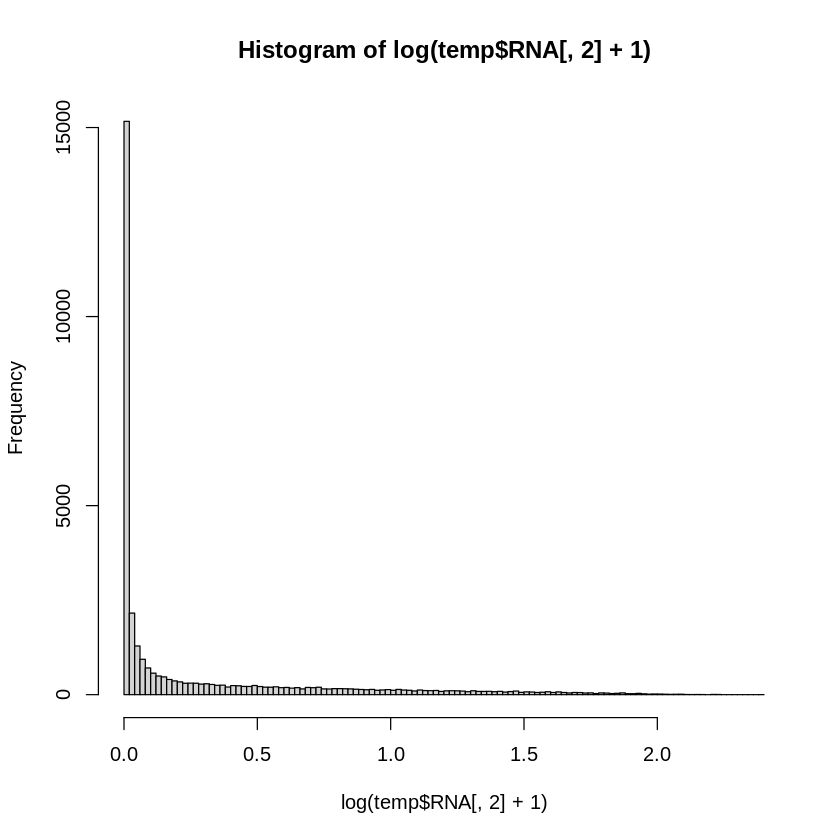

In [8]:
RNA_obj_by_linextime_lst[[1]]$RNA@scale.data <- as.matrix(RNA_obj_by_linextime_lst[[1]]$RNA@data)
temp <- AverageExpression(RNA_obj_by_linextime_lst[[1]], slot="scale.data", return.seurat = F, group.by="cell.time")
hist(log(temp$RNA[,2]+1), breaks = 100)

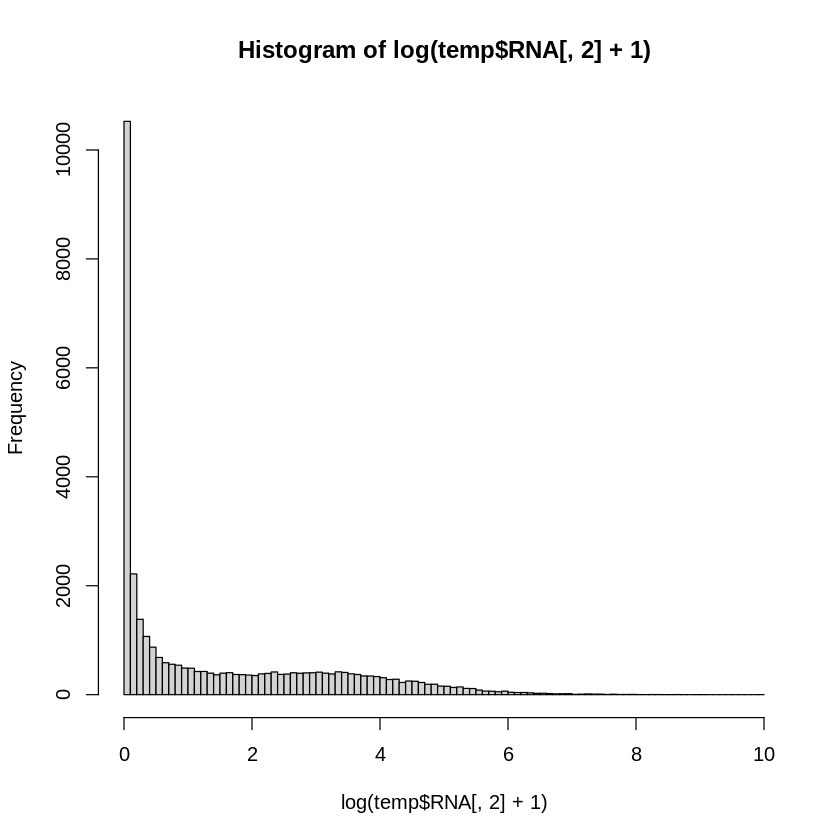

In [9]:
temp <- AverageExpression(RNA_obj_by_linextime_lst[[1]], slot="data", return.seurat = F, group.by="cell.time")
hist(log(temp$RNA[,2]+1), breaks = 100)

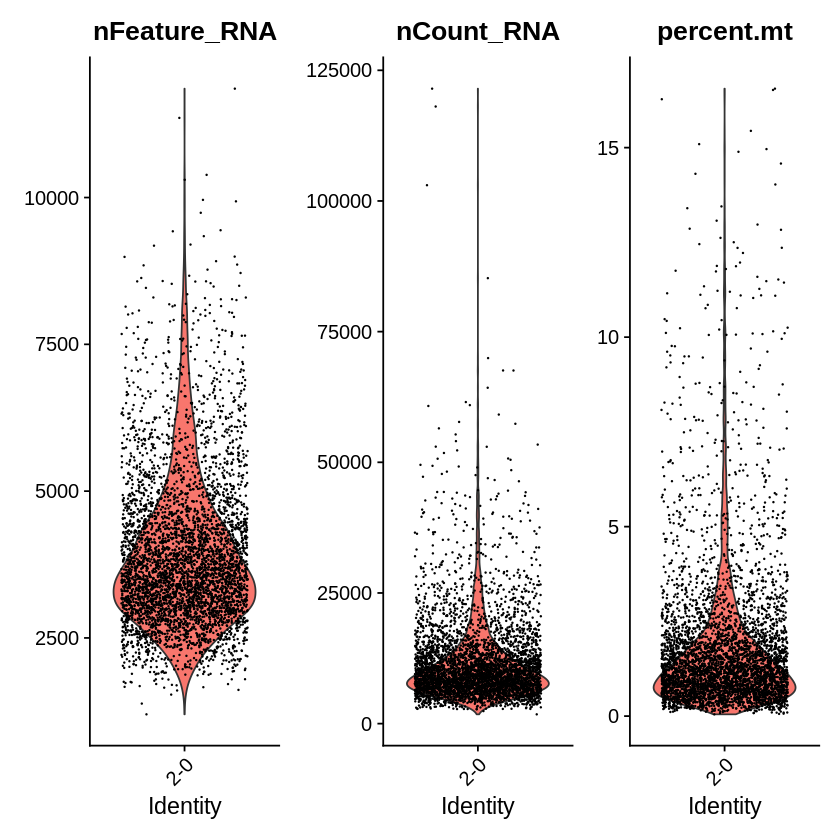

In [29]:
VlnPlot(RNA_obj_by_linextime_lst[[1]], features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [22]:
dat <- AggregateExpression(RNA_obj_by_linextime_lst[[1]], group.by = "cell.time", return.seurat = F)
dat

$RNA
                      0hr_GABA   0hr_nmglut   0hr_npglut    0hr_other
MIR1302-2HG       0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
FAM138A           0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
OR4F5             0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
AL627309.1        2.118360e+01 1.120170e+01 2.115681e+01 7.202054e+00
AL627309.3        0.000000e+00 1.118693e+00 1.034698e+00 2.243662e+00
AL627309.2        0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
AL627309.5        3.156516e+01 2.235869e+01 2.085928e+01 1.493727e+01
AL627309.4        0.000000e+00 0.000000e+00 0.000000e+00 1.913459e+00
AL732372.1        0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
OR4F29            0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
AC114498.1        0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
OR4F16            0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
AL669831.2        2.568207e+00 1.779919e+00 2.069784e+00 0.000000e+00
FAM87B            0.000000e+00 2.384640e+00 3.264667e-01 1.360280e+00
LINC01128         3.064362e+02 3.718554e+02 2.725854e+02 7.037200e+01
LINC00115         2.825494e+01 1.995825e+01 2.180659e+01 1.132174e+01
FAM41C            1.877750e+01 1.309091e+01 1.313850e+01 1.192255e+01
AL645608.6        7.992844e+01 8.169516e+01 4.391144e+01 8.419414e+00
AL645608.2        6.036455e+01 7.994021e+01 3.503201e+01 1.617921e+01
AL645608.4        0.000000e+00 0.000000e+00 1.071467e+00 0.000000e+00
LINC02593         4.020569e+01 1.059666e+02 6.059860e+01 2.533842e+01
SAMD11            2.073567e+02 3.294192e+02 1.864560e+02 3.851308e+01
NOC2L             3.848003e+02 3.831884e+02 2.619399e+02 1.292495e+02
KLHL17            5.048806e+01 8.747512e+01 6.450083e+01 9.691935e+00
PLEKHN1           8.445022e+00 9.933717e+00 5.577111e+00 1.516122e+00
PERM1             0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
AL645608.7        1.148965e+01 1.332517e+01 1.969823e+01 1.585540e+01
HES4              2.875596e+02 2.471212e+02 2.236157e+02 1.981408e+02
ISG15             6.039933e+01 6.532702e+01 6.524464e+01 3.933394e+01
AL645608.1        5.939164e+00 1.648323e+01 3.084840e+00 7.753445e+00
AGRN              4.326970e+02 4.298437e+02 4.040938e+02 1.838683e+02
AL645608.5        0.000000e+00 0.000000e+00 4.798464e-01 3.878073e-01
AL645608.8        1.742160e+00 0.000000e+00 0.000000e+00 0.000000e+00
RNF223            0.000000e+00 3.051665e-01 0.000000e+00 1.397819e+00
C1orf159          5.441769e+02 7.896531e+02 4.808129e+02 1.501729e+02
AL390719.3        4.920445e+01 6.781816e+01 5.054700e+01 1.419912e+01
LINC01342         0.000000e+00 2.400989e+00 0.000000e+00 0.000000e+00
AL390719.2        0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
TTLL10-AS1        0.000000e+00 5.582849e-01 0.000000e+00 0.000000e+00
TTLL10            3.761101e+00 8.667765e-01 8.626639e-01 2.155299e+00
TNFRSF18          0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
TNFRSF4           0.000000e+00 0.000000e+00 8.233742e-01 9.773464e-01
SDF4              4.545611e+02 5.054645e+02 2.955403e+02 2.127825e+02
B3GALT6           2.197584e+02 2.001362e+02 1.438260e+02 5.058434e+01
C1QTNF12          5.676142e+00 7.248932e+00 9.978087e+00 6.804793e+00
AL162741.1        0.000000e+00 1.363698e+00 0.000000e+00 0.000000e+00
UBE2J2            2.450139e+02 2.658532e+02 1.886599e+02 9.241115e+01
LINC01786         2.636030e+01 1.514333e+01 1.827673e+01 1.756474e+00
SCNN1D            1.820715e+01 2.749556e+01 1.568451e+01 8.227540e+00
ACAP3             6.007365e+02 7.901669e+02 5.803280e+02 1.918446e+02
PUSL1             2.556696e+01 1.347602e+01 1.324920e+01 9.410087e+00
INTS11            1.623873e+02 2.362560e+02 1.705024e+02 5.576493e+01
AL139287.1        1.767334e+00 2.844836e+00 0.000000e+00 0.000000e+00
CPTP              4.027679e+01 4.616723e+01 2.778366e+01 1.296668e+01
TAS1R3            4.785369e+00 6.449811e+00 8.437885e+00 0.000000e+00
DVL1              9.053151e+01 1.198047e+02 6.763651e+01 3.830090e+01
MXRA8

In [10]:
RNA_obj_by_linextime_lst[[1]]$cell.line.ident[[1]]

[1] "CD_27"